In [1]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


# Application of Enviorment 

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [3]:
# set simulation period
start_date = date(2019, 1, 1)
end_date = date(2019, 1, 31)

# calculate number of days to simulate
nr_iterations = (end_date - start_date).days

# Load data for simulation

### Car-sharing stations

In [4]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex
stations.head()

,station_no,geom
0,2901,POINT (2555501.836 1145060.068)
1,2905,POINT (2752963.411 1260089.916)
2,2910,POINT (2501877.645 1126218.900)
3,2913,POINT (2682234.096 1243208.370)
4,2918,POINT (2736874.744 1253090.505)


### Vehicle information

In [5]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)
vehicles.head()

,index,vehicle_category,vehicle_no,model_name,brand_name,charge_power,battery_capacity,range
0,2962,Minivan,106516,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
1,2963,Minivan,106517,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
2,2964,Minivan,106518,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
3,2965,Minivan,106519,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
4,2966,Combi,106526,Enyaq iV80,Skoda,11.0,82.0,420.0


### Reservations

In [6]:
# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations)
    reservations = pd.read_sql(sql, engine)
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta
reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
0,24519221,3165,116525,0.0,0.0,96.0,96.0,0.00,0.000000,0.00,0.0,97.0
1,24519192,2886,114874,0.0,0.0,4.0,6.0,10.50,5.384615,5.25,14.0,4.0
2,24514447,2702,114871,0.0,4.0,5.0,6.0,2.66,1.538462,7.50,4.0,2.0
3,24519174,1557,115969,0.0,0.0,49.0,50.0,45.75,30.500000,43.75,61.0,50.0
4,24519097,4407,113833,0.0,2.0,9.0,10.0,13.00,10.000000,6.25,20.0,7.0


### Electicity prices for charging

In [7]:
# get charging costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)

sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

charging_costs = pd.read_sql(sql, engine)
charging_costs.head()

,Price_chf_kwh_0.0,Price_chf_kwh_0.25,Price_chf_kwh_0.5,Price_chf_kwh_0.75,Price_chf_kwh_1.0,Price_chf_kwh_1.25,Price_chf_kwh_1.5,Price_chf_kwh_1.75,Price_chf_kwh_2.0,Price_chf_kwh_2.25,...,Price_chf_kwh_21.75,Price_chf_kwh_22.0,Price_chf_kwh_22.25,Price_chf_kwh_22.5,Price_chf_kwh_22.75,Price_chf_kwh_23.0,Price_chf_kwh_23.25,Price_chf_kwh_23.5,Price_chf_kwh_23.75,Delivery day
0,0.054160,0.054160,0.054160,0.054160,0.052522,0.052522,0.052522,0.052522,0.050906,0.050906,...,0.054634,0.059397,0.059397,0.059397,0.059397,0.059387,0.059387,0.059387,0.059387,2019-01-01
1,0.053848,0.053848,0.053848,0.053848,0.052436,0.052436,0.052436,0.052436,0.044785,0.044785,...,0.065669,0.064731,0.064731,0.064731,0.064731,0.063546,0.063546,0.063546,0.063546,2019-01-02
2,0.057145,0.057145,0.057145,0.057145,0.054419,0.054419,0.054419,0.054419,0.052070,0.052070,...,0.067910,0.065755,0.065755,0.065755,0.065755,0.061800,0.061800,0.061800,0.061800,2019-01-03
3,0.056671,0.056671,0.056671,0.056671,0.055701,0.055701,0.055701,0.055701,0.053826,0.053826,...,0.069678,0.069764,0.069764,0.069764,0.069764,0.065410,0.065410,0.065410,0.065410,2019-01-04
4,0.067953,0.067953,0.067953,0.067953,0.063018,0.063018,0.063018,0.063018,0.058977,0.058977,...,0.064548,0.065874,0.065874,0.065874,0.065874,0.065863,0.065863,0.065863,0.065863,2019-01-05


In [8]:
# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

### Secondary energy prices (for V2G)

In [9]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)
v2g_prices.head()

,Timestamp,Secondary_positive_v2g_prices_chf_kwh,Secondary_negative_v2g_prices_chf_kwh
0,2019-01-01 00:00:00,0.068370,0.045588
1,2019-01-01 00:15:00,0.068838,0.045896
2,2019-01-01 00:30:00,0.068838,0.045896
3,2019-01-01 00:45:00,0.068838,0.045896
4,2019-01-01 01:00:00,0.068838,0.045896


In [10]:
# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

### Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. For your task, it is important that "planned_bookings" is set to "False". You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

# Your Task

In [11]:
env = CarsharingEnv(stations, vehicles, planned_bookings = True, plot_state_histogram = False, plot_state_animation = False, max_distance_car_assingment = 500, v2g_penalty = 10000, penalty_per_kwh = 0)

In [12]:
def your_v2g_strategy(state, nr_vehicles):
    # state has length of nr_vehicles * 4 + 2
        
    # get current locations of vehicles (station number integer between 1000 and 5000, reservation number integer between 20000000 and 40000000, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (float between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
    
    # get planned reservations of vehicles, integer between 0 and 55392
    planned_reservations = state[nr_vehicles * 2:nr_vehicles * 3]
    
    # get durations of planned reservations of vehicles, integer between 0 and 55392
    planned_reservations = state[nr_vehicles * 3:nr_vehicles * 4]
        
    # check if V2G event will take place and get demand in the next timestep (0 = no V2G event, positive integer between 500 and 1000 = discharging event, negative integer between 500 and 1000 = charging event)
    v2g_event = state[nr_vehicles * 4:nr_vehicles * 4 + 1]
    
    # get current simulation time, integer between 0 and 55392
    current_time = state[nr_vehicles * 4 + 1:]
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # charge all vehicles
    action = np.ones(nr_vehicles)
    
    # discharge all vehicles
    #action = np.full(nr_vehicles, 2)
    
    # do nothing
    #action = np.zeros(nr_vehicles)
    
    # send action to enviroment
    return action
    
    

### Start simulation

Start simulation:

Data loading:  0.0
Reward in this step: -422.4976260342948  time:  1
Reward in this step: -173.67049033929982  time:  2
Reward in this step: -73.58736931336006  time:  3
Reward in this step: -61.41978584344338  time:  4
Reward in this step: 0.8902453285126626  time:  5
Reward in this step: 129.8932861106477  time:  6
Reward in this step: 11.271803554048546  time:  7
Reward in this step: 64.24034900214707  time:  8
Reward in this step: -53.565046250674115  time:  9
Reward in this step: -66.76000047573622  time:  10
Reward in this step: 30.646640385723373  time:  11
Reward in this step: 11.625382864213144  time:  12
Reward in this step: 238.7415743516301  time:  13
Reward in this step: 86.43780790692443  time:  14
Reward in this step: 89.95872599330104  time:  15
Reward in this step: 25.53950719267198  time:  16
Reward in this step: 62.482794624024166  time:  17
Reward in this step: 86.73646363314015  time:  18
Reward in this step: 42.052959759590586  time:  19
Reward in this step: 8.422

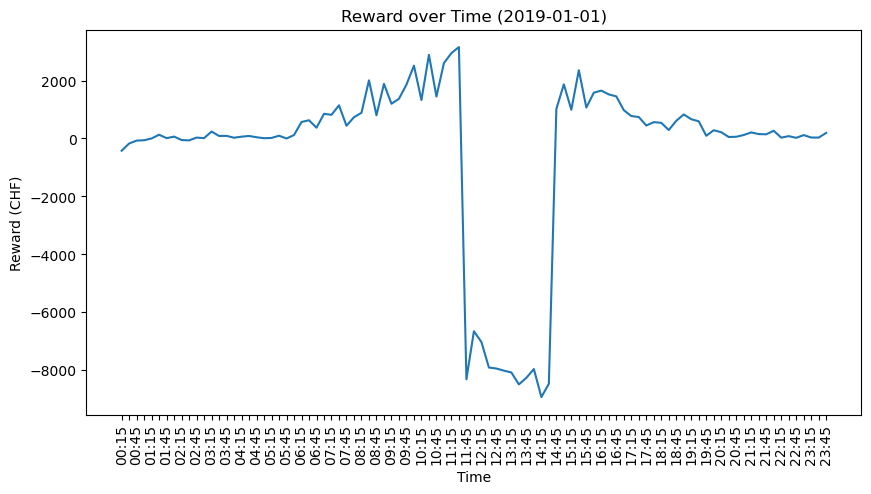

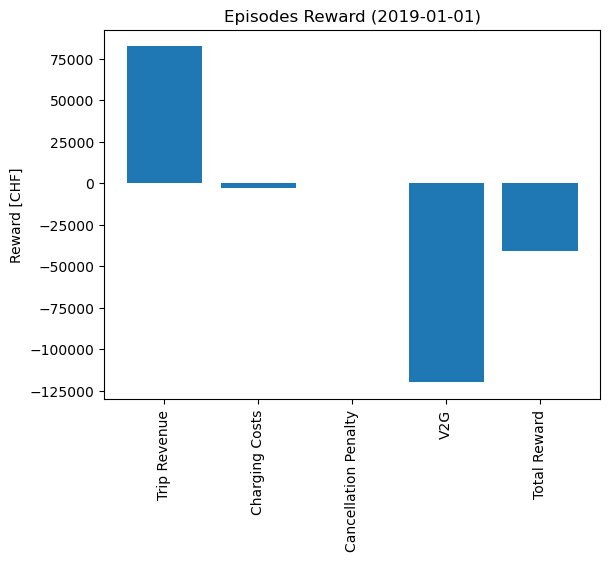

Total reward 2019-01-01:
-40712.33691060171

Total Episode Time:  0.5662093162536621

Data loading:  0.0
Reward in this step: 51.02599224795823  time:  96
Reward in this step: 29.02082999349539  time:  97
Reward in this step: -6.004701407030728  time:  98
Reward in this step: 157.9698979158453  time:  99
Reward in this step: 46.66486139563562  time:  100
Reward in this step: -2.825125773689668  time:  101
Reward in this step: 55.14194864893539  time:  102
Reward in this step: -2.980445310486182  time:  103
Reward in this step: 10.0717034649055  time:  104
Reward in this step: 24.455535396114286  time:  105
Reward in this step: 28.854424792344616  time:  106
Reward in this step: -1.414258752937142  time:  107
Reward in this step: 13.756005346905733  time:  108
Reward in this step: -1.0069133732399995  time:  109
Reward in this step: -0.9147850927199991  time:  110
Reward in this step: 4.970032589749205  time:  111
Reward in this step: 58.66725182245275  time:  112
Reward in this step: -

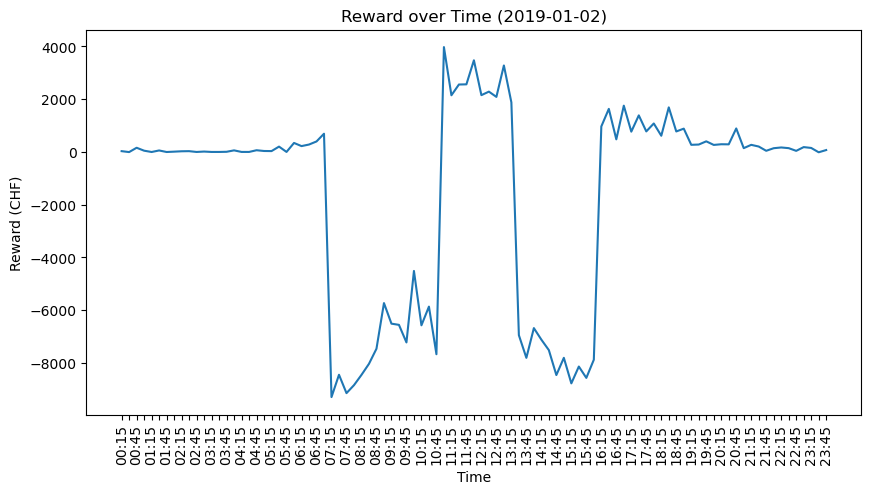

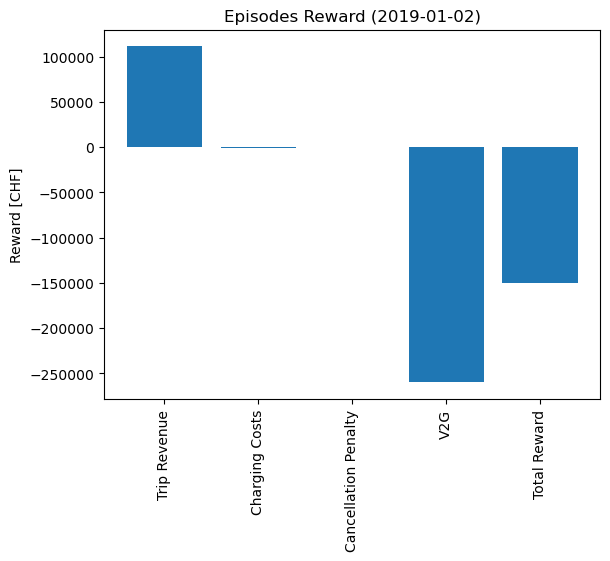

Total reward 2019-01-02:
-150036.262462882

Total Episode Time:  0.7636356353759766

Data loading:  0.0
Reward in this step: 13.322791330556289  time:  192
Reward in this step: 56.09131565961319  time:  193
Reward in this step: 5.6379465530184145  time:  194
Reward in this step: 126.79144386171649  time:  195
Reward in this step: 107.12413298762682  time:  196
Reward in this step: -4.668714142010054  time:  197
Reward in this step: 33.150002760341884  time:  198
Reward in this step: -2.886241590065932  time:  199
Reward in this step: 125.29204484446154  time:  200
Reward in this step: 12.39737084502271  time:  201
Reward in this step: -1.8737257075199998  time:  202
Reward in this step: -1.4945100161828546  time:  203
Reward in this step: -1.348975394742857  time:  204
Reward in this step: 8.624190120228572  time:  205
Reward in this step: 72.80071165459691  time:  206
Reward in this step: 133.22756245942855  time:  207
Reward in this step: -0.46370938368000025  time:  208
Reward in th

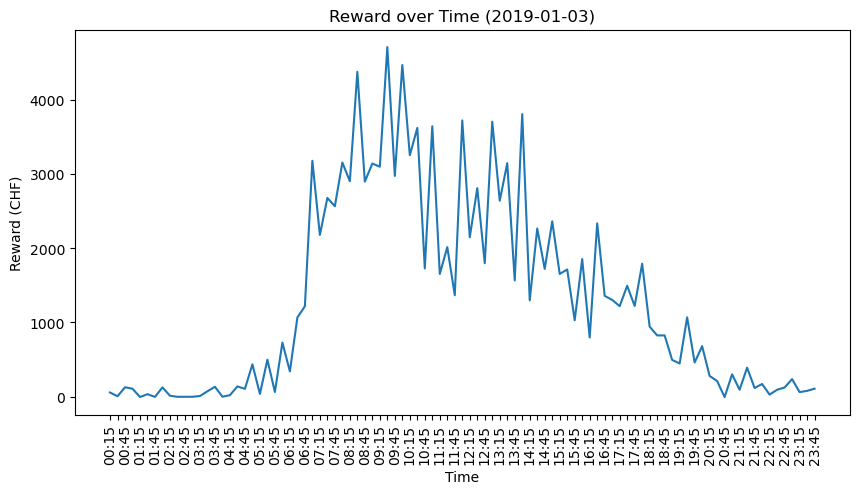

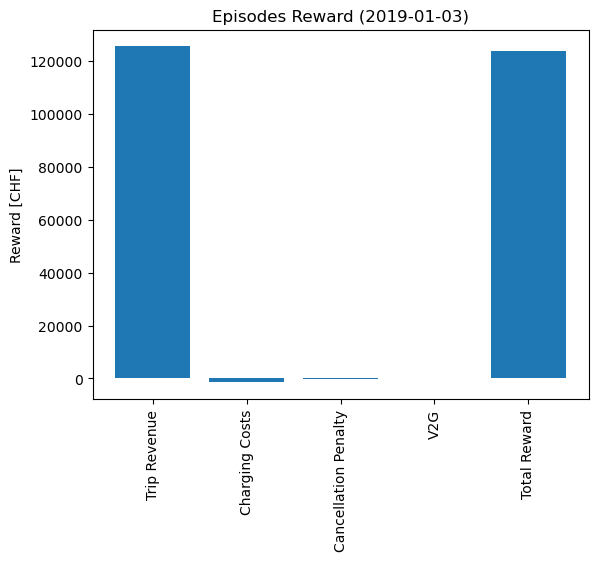

Total reward 2019-01-03:
123786.65950463217

Total Episode Time:  0.8701403141021729

Data loading:  0.0
Reward in this step: 38.685087752571434  time:  288
Reward in this step: 132.0892331037461  time:  289
Reward in this step: 92.38485783095379  time:  290
Reward in this step: 273.10737490162893  time:  291
Reward in this step: 45.75538171589407  time:  292
Reward in this step: 42.61659719463871  time:  293
Reward in this step: -4.9965017747195555  time:  294
Reward in this step: 0.2340656565441801  time:  295
Reward in this step: 94.7202731456  time:  296
Reward in this step: -2.6715150974043977  time:  297
Reward in this step: 92.41165264771429  time:  298
Reward in this step: -2.4452141623516472  time:  299
Reward in this step: -2.149423859729663  time:  300
Reward in this step: 20.06737196003429  time:  301
Reward in this step: 70.5518927332  time:  302
Reward in this step: 91.15008861213141  time:  303
Reward in this step: 102.4644926724  time:  304
Reward in this step: 8.708441

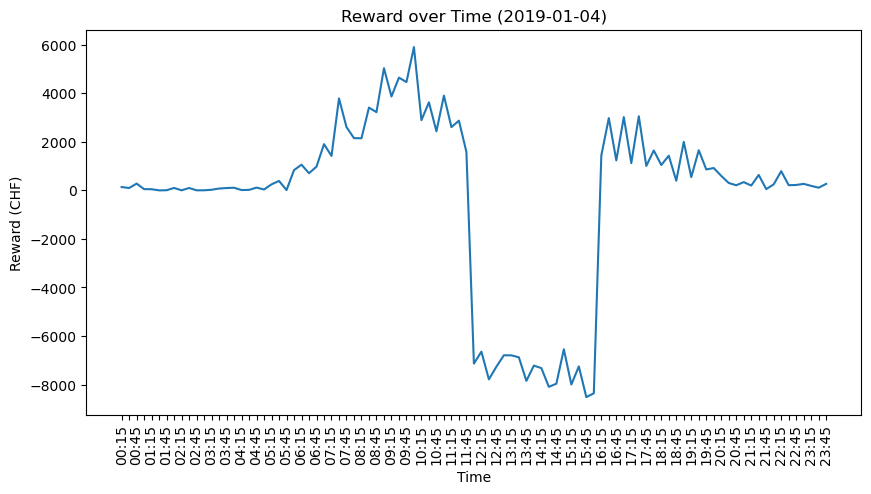

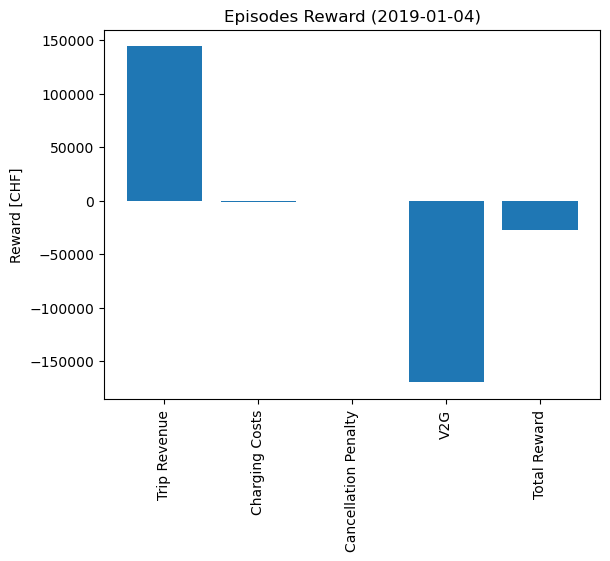

Total reward 2019-01-04:
-27894.916749168497

Total Episode Time:  0.9632256031036377

Data loading:  0.0
Reward in this step: 368.68045946353936  time:  384
Reward in this step: 191.37033601744835  time:  385
Reward in this step: 277.8863712948448  time:  386
Reward in this step: 114.23278664910592  time:  387
Reward in this step: 405.17251876160174  time:  388
Reward in this step: -8.102836374129224  time:  389
Reward in this step: 4.293166499439899  time:  390
Reward in this step: 49.00773693296247  time:  391
Reward in this step: 96.85920678062028  time:  392
Reward in this step: 94.12078773729428  time:  393
Reward in this step: -3.705677958476587  time:  394
Reward in this step: -2.813530319479998  time:  395
Reward in this step: 50.6487207108  time:  396
Reward in this step: -2.6824309501058106  time:  397
Reward in this step: 45.03161215430681  time:  398
Reward in this step: 81.50788738175737  time:  399
Reward in this step: 209.61186047252923  time:  400
Reward in this step: 

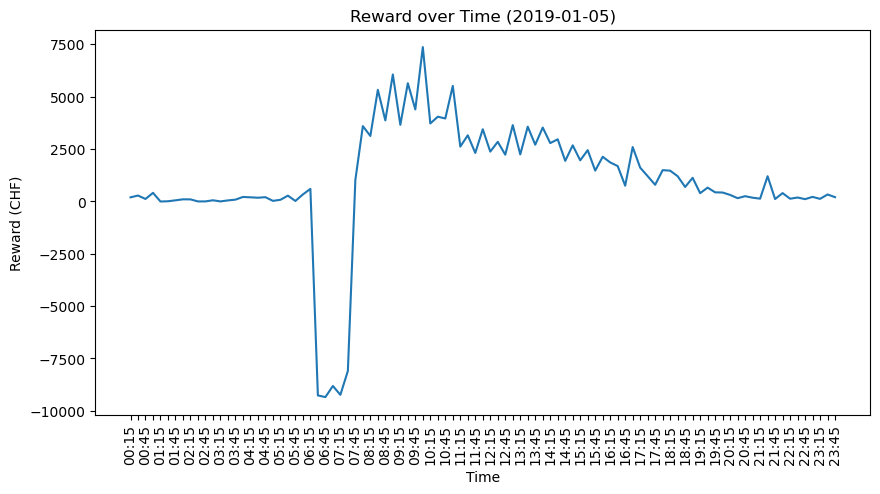

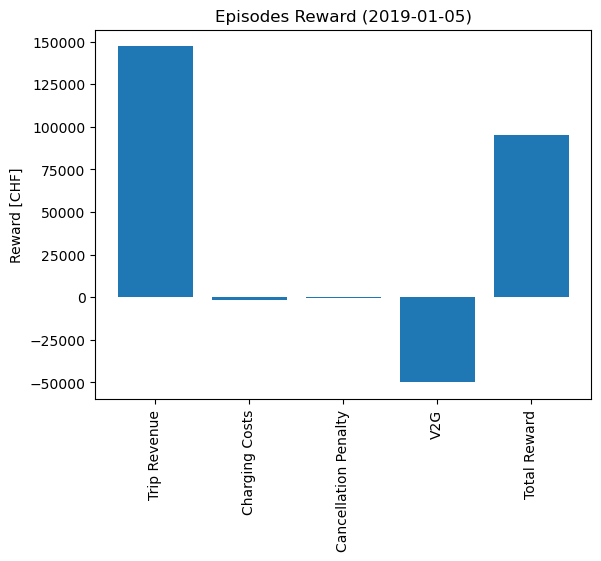

Total reward 2019-01-05:
95286.21083145484

Total Episode Time:  1.104705572128296

Data loading:  0.0
Reward in this step: 73.94822856396615  time:  480
Reward in this step: -1.148733161193693  time:  481
Reward in this step: 231.0730163595447  time:  482
Reward in this step: 169.2467374491562  time:  483
Reward in this step: 898.0215535642435  time:  484
Reward in this step: 8.786926461832486  time:  485
Reward in this step: 45.372389913961854  time:  486
Reward in this step: -10.120691761366153  time:  487
Reward in this step: 207.40063412567386  time:  488
Reward in this step: 26.8841221674872  time:  489
Reward in this step: 60.94697222342655  time:  490
Reward in this step: 18.38153998899019  time:  491
Reward in this step: 4.477463994480003  time:  492
Reward in this step: -4.421869736388637  time:  493
Reward in this step: 41.83024784311429  time:  494
Reward in this step: 24.40747393554945  time:  495
Reward in this step: 54.607092099896704  time:  496
Reward in this step: 72.

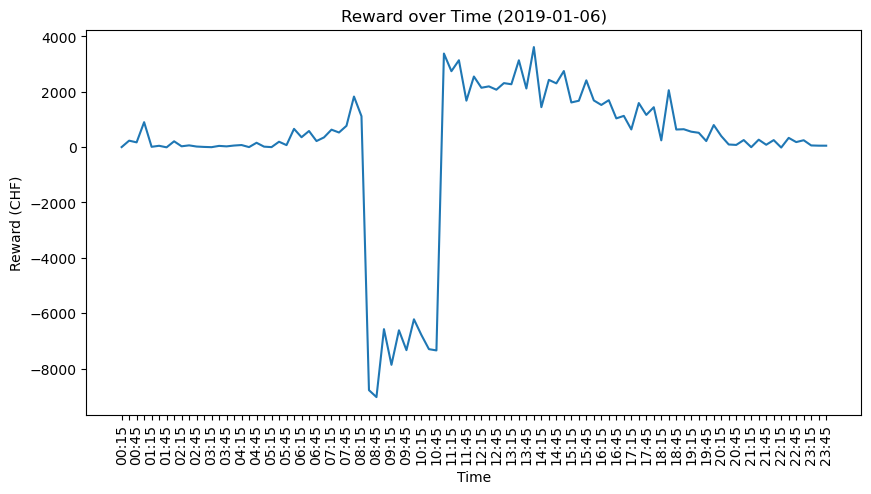

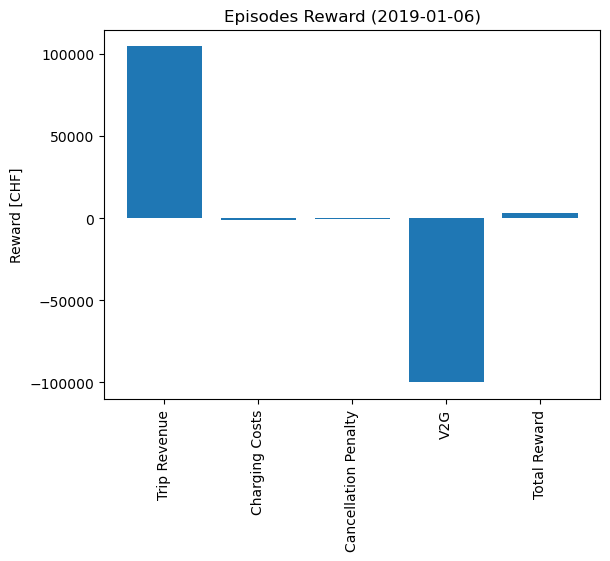

Total reward 2019-01-06:
3183.096004410487

Total Episode Time:  0.7828984260559082

Data loading:  0.0
Reward in this step: 80.62999145335561  time:  576
Reward in this step: 45.40058919686567  time:  577
Reward in this step: 69.17463882360177  time:  578
Reward in this step: 145.06685802086858  time:  579
Reward in this step: 80.88011645612397  time:  580
Reward in this step: 72.30807211579385  time:  581
Reward in this step: 8.5403577936  time:  582
Reward in this step: -2.587755374999999  time:  583
Reward in this step: 48.572258888910774  time:  584
Reward in this step: -2.0559278656061486  time:  585
Reward in this step: 14.047697462664615  time:  586
Reward in this step: -1.0031701679999971  time:  587
Reward in this step: 175.1197723944  time:  588
Reward in this step: 31.940985382857143  time:  589
Reward in this step: 62.872277728  time:  590
Reward in this step: -0.2559153856914262  time:  591
Reward in this step: 25.879867818806154  time:  592
Reward in this step: 30.224942

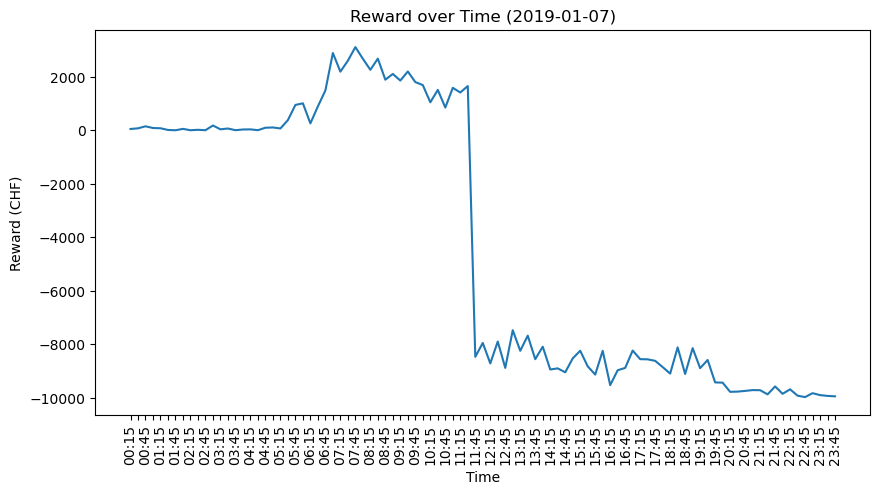

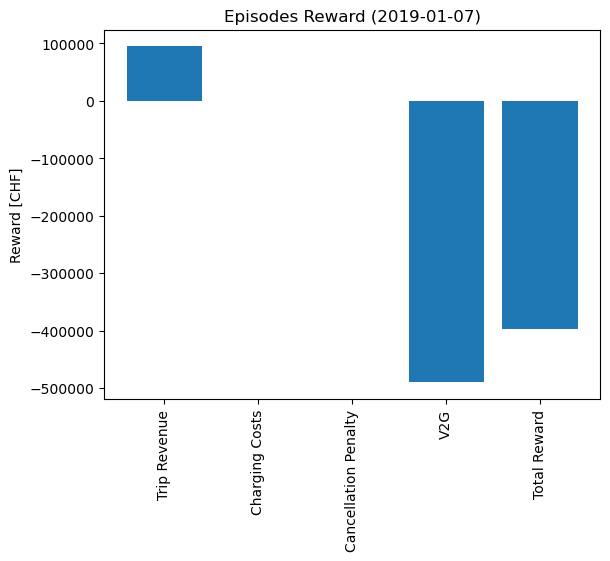

Total reward 2019-01-07:
-396449.4327566281

Total Episode Time:  0.8879611492156982

Data loading:  0.0
Reward in this step: -9935.105699964997  time:  672
Reward in this step: 37.85820759232954  time:  673
Reward in this step: 20.200846396571432  time:  674
Reward in this step: 276.40302437938107  time:  675
Reward in this step: 23.542093937816265  time:  676
Reward in this step: 8.580276886049232  time:  677
Reward in this step: -1.467186010067691  time:  678
Reward in this step: -0.9499777555476916  time:  679
Reward in this step: 133.686240348  time:  680
Reward in this step: 170.93195514759998  time:  681
Reward in this step: -0.5279387618399992  time:  682
Reward in this step: -0.6472579117846159  time:  683
Reward in this step: -0.41273787995999967  time:  684
Reward in this step: -0.3287508674399999  time:  685
Reward in this step: 46.440583964000005  time:  686
Reward in this step: 33.4556841704  time:  687
Reward in this step: 92.05581461215075  time:  688
Reward in this ste

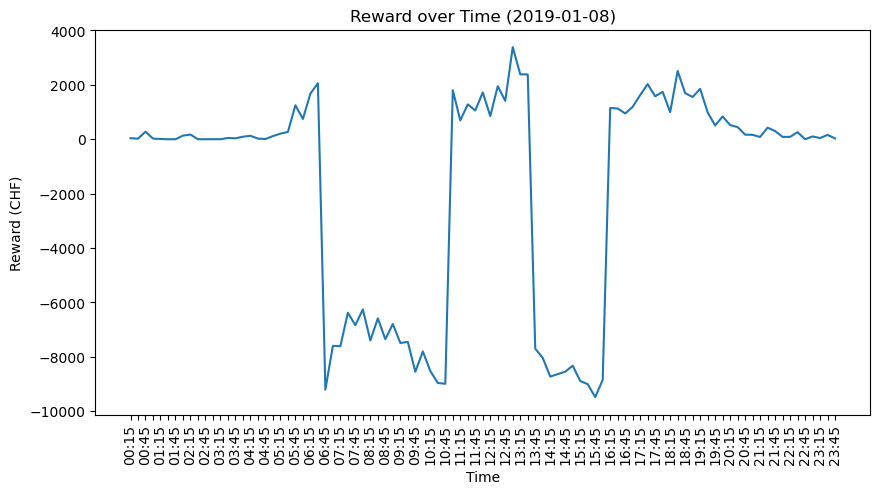

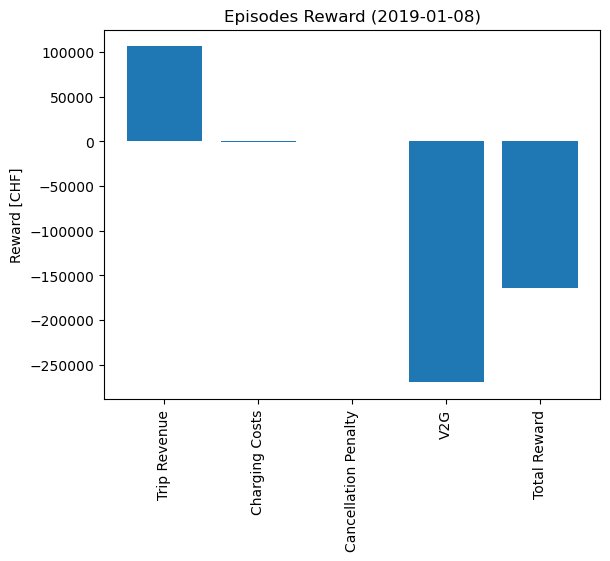

Total reward 2019-01-08:
-164590.94136642973

Total Episode Time:  0.9002206325531006

Data loading:  0.0
Reward in this step: 73.80108517843246  time:  768
Reward in this step: 407.79418763004526  time:  769
Reward in this step: 173.3332351520677  time:  770
Reward in this step: 307.70334536369273  time:  771
Reward in this step: 67.58378121356108  time:  772
Reward in this step: -3.255858651176698  time:  773
Reward in this step: 161.2137153759657  time:  774
Reward in this step: 100.7988419952057  time:  775
Reward in this step: 12.61827382149143  time:  776
Reward in this step: 63.16511985846413  time:  777
Reward in this step: 55.68780696697846  time:  778
Reward in this step: -1.2887745779999986  time:  779
Reward in this step: 30.3777475116  time:  780
Reward in this step: 234.14431205504616  time:  781
Reward in this step: 78.18132369765715  time:  782
Reward in this step: 97.14101142544001  time:  783
Reward in this step: -1.0373737308  time:  784
Reward in this step: 81.35996

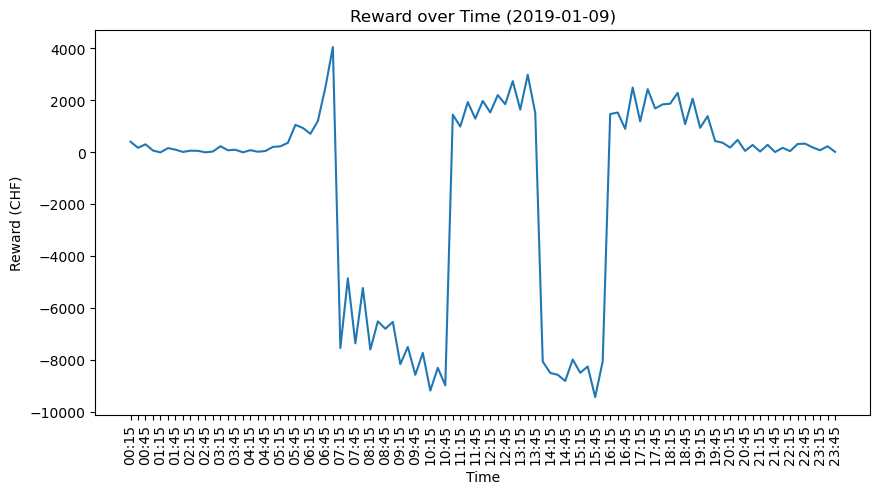

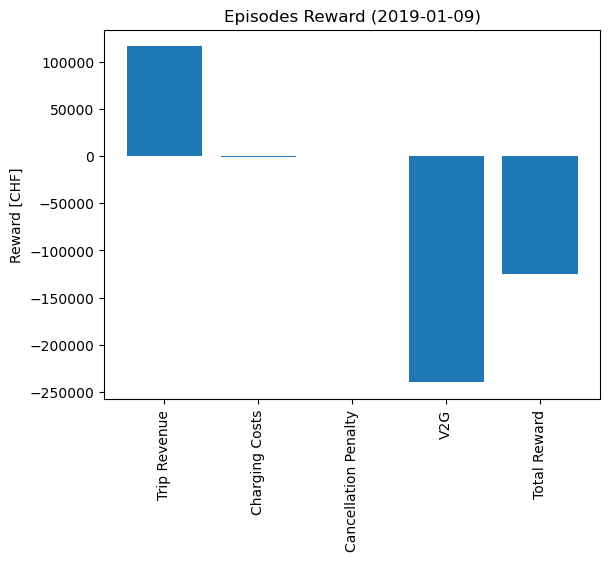

Total reward 2019-01-09:
-124993.65548854398

Total Episode Time:  0.9662055969238281

Data loading:  0.0
Reward in this step: 75.8062780048879  time:  864
Reward in this step: 118.00007114907035  time:  865
Reward in this step: -0.11326201377408118  time:  866
Reward in this step: 252.5777845598031  time:  867
Reward in this step: 102.56267639803077  time:  868
Reward in this step: 31.737165348319998  time:  869
Reward in this step: -3.4159356723085703  time:  870
Reward in this step: -2.8333307089028525  time:  871
Reward in this step: 117.77438954961143  time:  872
Reward in this step: -2.4434943354443934  time:  873
Reward in this step: 156.83938910481538  time:  874
Reward in this step: -1.403469141230768  time:  875
Reward in this step: 58.66615581400001  time:  876
Reward in this step: -0.7411129343999999  time:  877
Reward in this step: -0.9003364164  time:  878
Reward in this step: -0.7627562994857136  time:  879
Reward in this step: 46.88006172086858  time:  880
Reward in thi

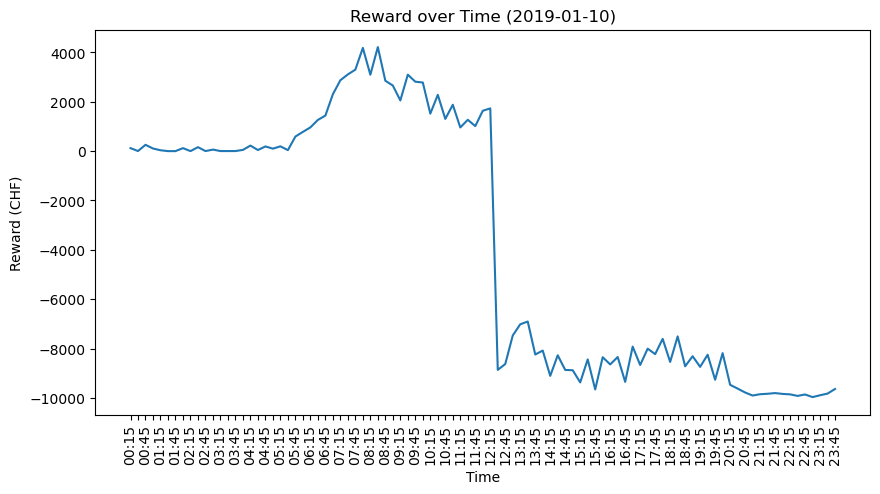

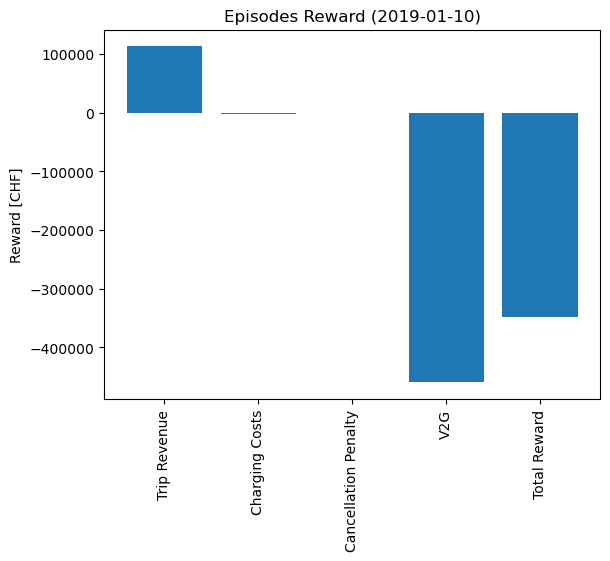

Total reward 2019-01-10:
-347915.4630287759

Total Episode Time:  1.0154500007629395

Data loading:  0.0
Reward in this step: 68.73204141742858  time:  960
Reward in this step: 113.94663234564571  time:  961
Reward in this step: 112.33633938550858  time:  962
Reward in this step: 320.28957670368004  time:  963
Reward in this step: 236.5056800900968  time:  964
Reward in this step: 34.721025055839995  time:  965
Reward in this step: 7.728811248869452  time:  966
Reward in this step: 92.60246967580572  time:  967
Reward in this step: 117.74613409674154  time:  968
Reward in this step: -2.2727970914414084  time:  969
Reward in this step: 19.444614825125274  time:  970
Reward in this step: -1.3513056419815372  time:  971
Reward in this step: -0.968309642215385  time:  972
Reward in this step: 16.968118049485714  time:  973
Reward in this step: 44.44378508116  time:  974
Reward in this step: -1.059842047236923  time:  975
Reward in this step: 40.365878994525715  time:  976
Reward in this st

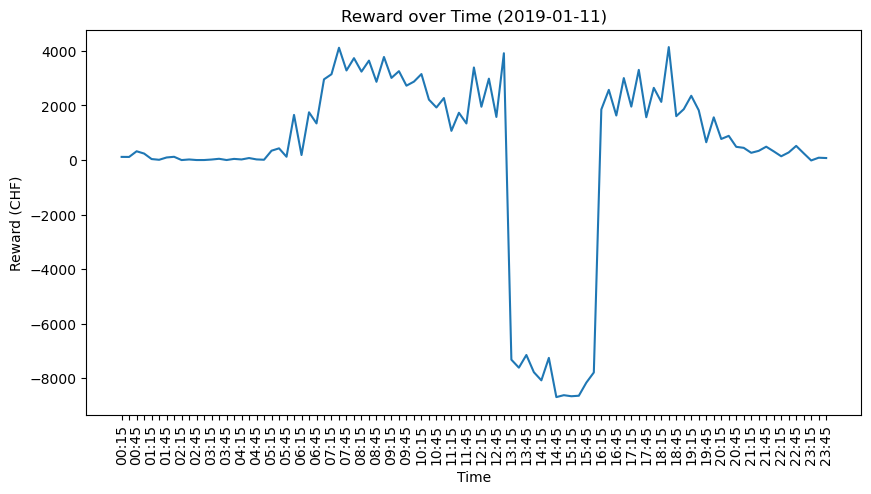

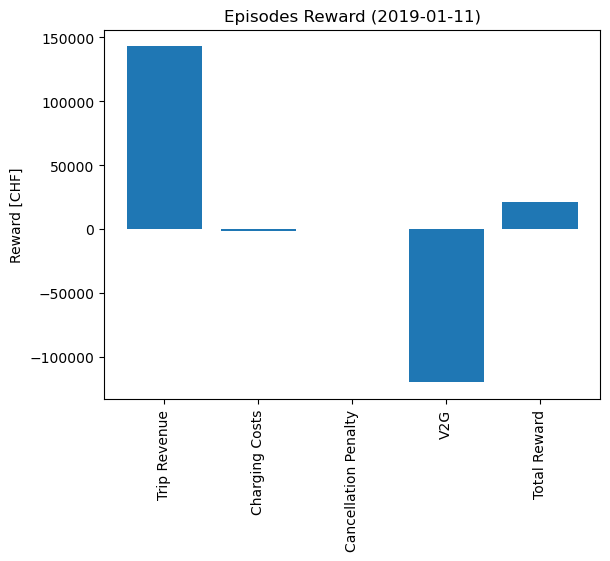

Total reward 2019-01-11:
21452.604389462544

Total Episode Time:  1.0341436862945557

Data loading:  0.0
Reward in this step: 74.75234576723958  time:  1056
Reward in this step: 156.34304309768942  time:  1057
Reward in this step: 142.163494530164  time:  1058
Reward in this step: 146.64641856420377  time:  1059
Reward in this step: 59.95896981923429  time:  1060
Reward in this step: 51.832046337924595  time:  1061
Reward in this step: 88.49015910341242  time:  1062
Reward in this step: 171.22391671423122  time:  1063
Reward in this step: 90.7632517503598  time:  1064
Reward in this step: 8.750295124326154  time:  1065
Reward in this step: -4.6572202962554  time:  1066
Reward in this step: -3.839502934519995  time:  1067
Reward in this step: -3.397396723024613  time:  1068
Reward in this step: -2.907122542099341  time:  1069
Reward in this step: -2.5548442193261542  time:  1070
Reward in this step: 58.76506513482462  time:  1071
Reward in this step: 131.96621132617142  time:  1072
Rewa

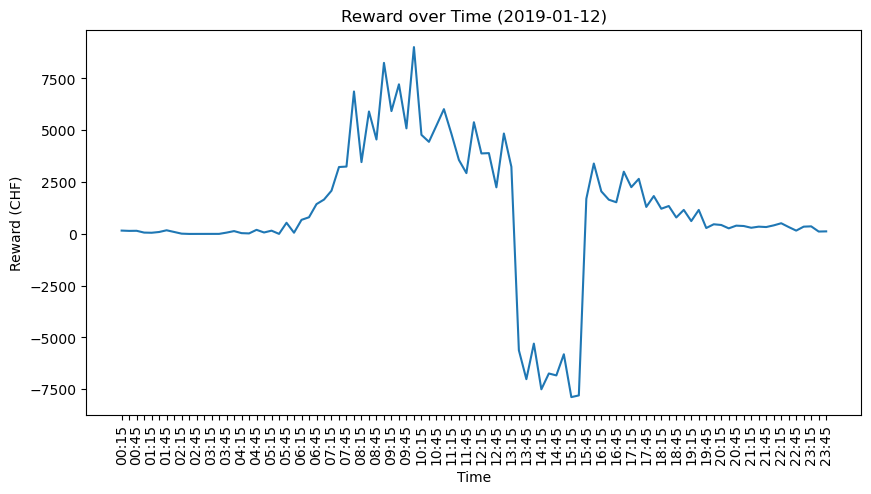

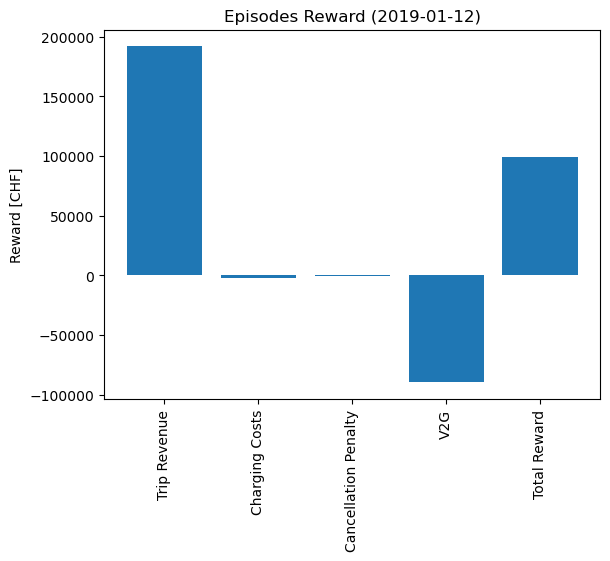

Total reward 2019-01-12:
99428.04904504209

Total Episode Time:  1.2506649494171143

Data loading:  0.0
Reward in this step: 226.21983491156385  time:  1152
Reward in this step: -9935.49771040203  time:  1153
Reward in this step: -9808.04427962317  time:  1154
Reward in this step: -9829.70324961973  time:  1155
Reward in this step: -9996.550058617622  time:  1156
Reward in this step: -9905.241655272888  time:  1157
Reward in this step: -10009.261126973155  time:  1158
Reward in this step: -10002.630485445434  time:  1159
Reward in this step: -9965.747840492513  time:  1160
Reward in this step: -9874.944746231698  time:  1161
Reward in this step: -10006.508924156444  time:  1162
Reward in this step: -9979.153910448213  time:  1163
Reward in this step: -10005.32016095749  time:  1164
Reward in this step: -9986.195172525444  time:  1165
Reward in this step: -9939.82318048912  time:  1166
Reward in this step: -10003.619431477966  time:  1167
Reward in this step: -9946.071666005862  time:  

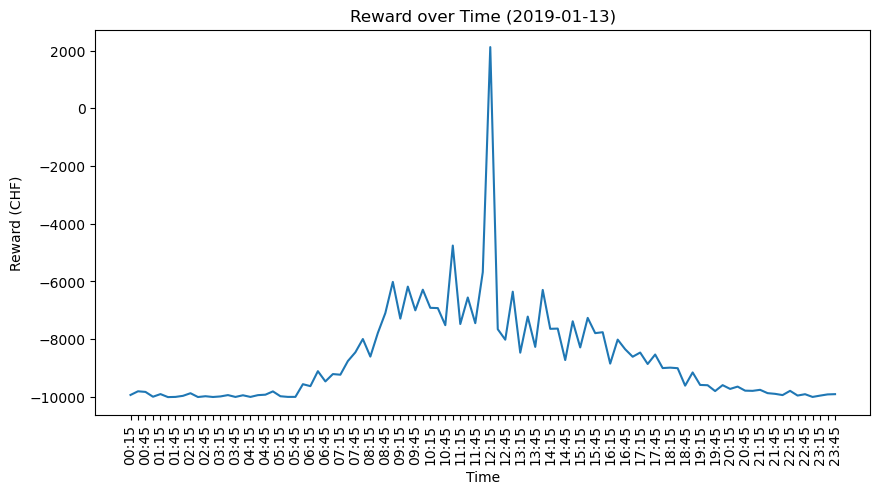

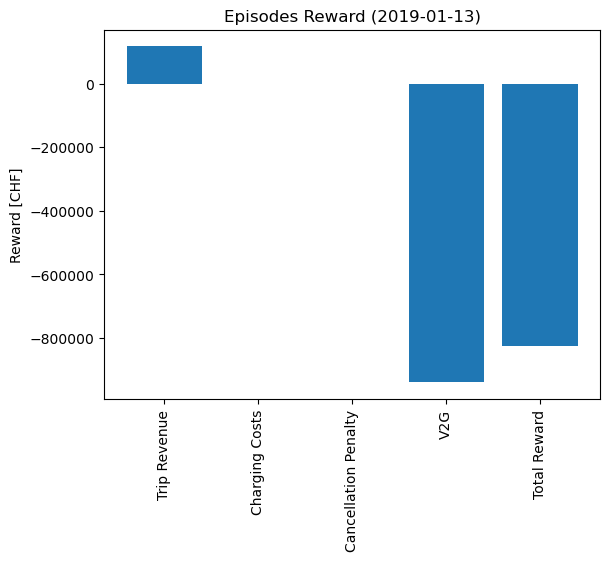

Total reward 2019-01-13:
-824390.9323272309

Total Episode Time:  0.8886048793792725

Data loading:  0.0
Reward in this step: 148.8451024250532  time:  1248
Reward in this step: 157.8843830558401  time:  1249
Reward in this step: 7.718281231879523  time:  1250
Reward in this step: 178.35883709515687  time:  1251
Reward in this step: 54.738675501792535  time:  1252
Reward in this step: -3.5174795730671553  time:  1253
Reward in this step: 28.46708315909846  time:  1254
Reward in this step: 32.91464580230286  time:  1255
Reward in this step: 10.396376591514287  time:  1256
Reward in this step: -2.204275893415385  time:  1257
Reward in this step: 47.956603828000006  time:  1258
Reward in this step: 19.857581713384615  time:  1259
Reward in this step: -2.003167317142856  time:  1260
Reward in this step: 29.9410651068  time:  1261
Reward in this step: 42.049594769760006  time:  1262
Reward in this step: 6.145034639280851  time:  1263
Reward in this step: 109.25513845488177  time:  1264
Rewa

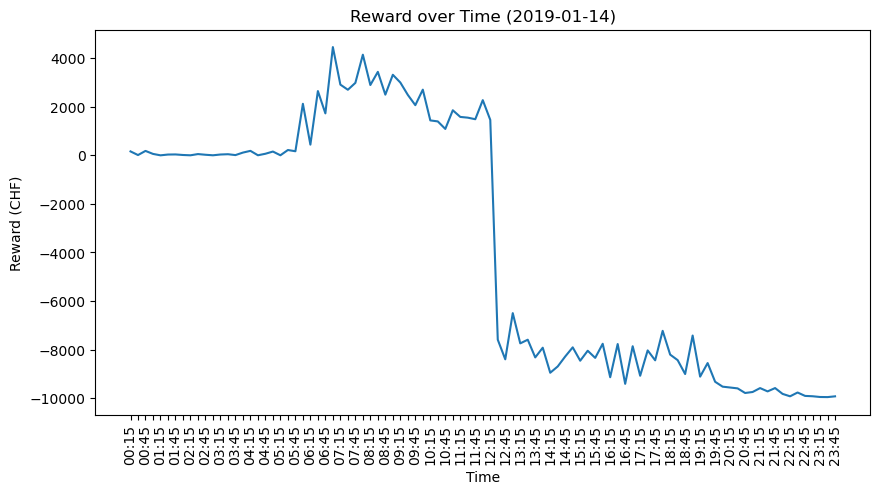

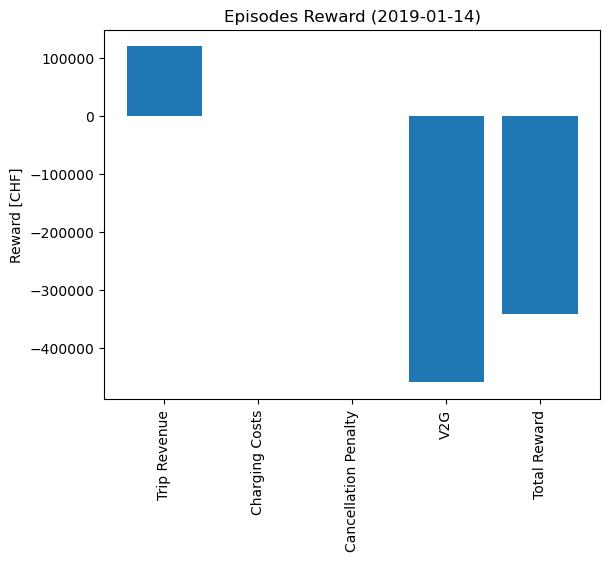

Total reward 2019-01-14:
-341861.657800799

Total Episode Time:  0.9660887718200684

Data loading:  0.0
Reward in this step: -9970.572859752947  time:  1344
Reward in this step: -9919.402012752666  time:  1345
Reward in this step: -9989.912449118598  time:  1346
Reward in this step: -9878.022287837981  time:  1347
Reward in this step: -9996.858051670228  time:  1348
Reward in this step: -10003.12623737524  time:  1349
Reward in this step: -10002.84649994048  time:  1350
Reward in this step: -10002.360979009933  time:  1351
Reward in this step: -9891.291118782508  time:  1352
Reward in this step: -9983.025543800888  time:  1353
Reward in this step: -10001.287697239703  time:  1354
Reward in this step: -10001.0562074848  time:  1355
Reward in this step: -10001.0562074848  time:  1356
Reward in this step: -10001.001370781258  time:  1357
Reward in this step: -9941.427131429029  time:  1358
Reward in this step: -9603.2924607768  time:  1359
Reward in this step: -9927.728103091724  time:  1

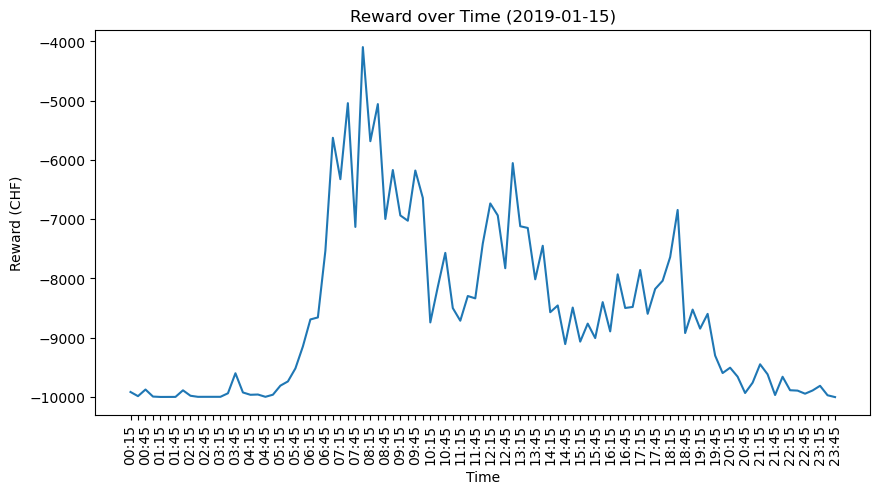

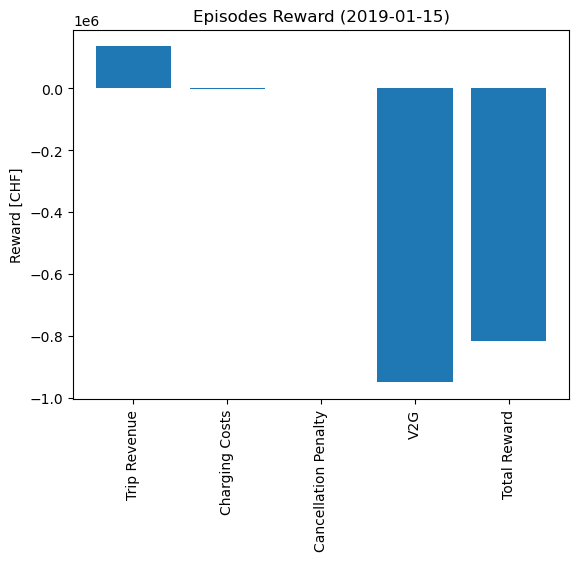

Total reward 2019-01-15:
-815820.6462002032

Total Episode Time:  0.9922621250152588

Data loading:  0.0
Reward in this step: -9913.015225719359  time:  1440
Reward in this step: -9798.441319474467  time:  1441
Reward in this step: -9507.67688309746  time:  1442
Reward in this step: -9834.607009115063  time:  1443
Reward in this step: -9947.002555042338  time:  1444
Reward in this step: -10004.215765557989  time:  1445
Reward in this step: -9978.547518984  time:  1446
Reward in this step: -9996.29717828  time:  1447
Reward in this step: -9906.180896386331  time:  1448
Reward in this step: -10001.819307040148  time:  1449
Reward in this step: -10001.377946036024  time:  1450
Reward in this step: -10001.263764637342  time:  1451
Reward in this step: -9796.86888385864  time:  1452
Reward in this step: -9947.900346706343  time:  1453
Reward in this step: -9949.0097020196  time:  1454
Reward in this step: -9935.425885753657  time:  1455
Reward in this step: -9953.5320787736  time:  1456
Rew

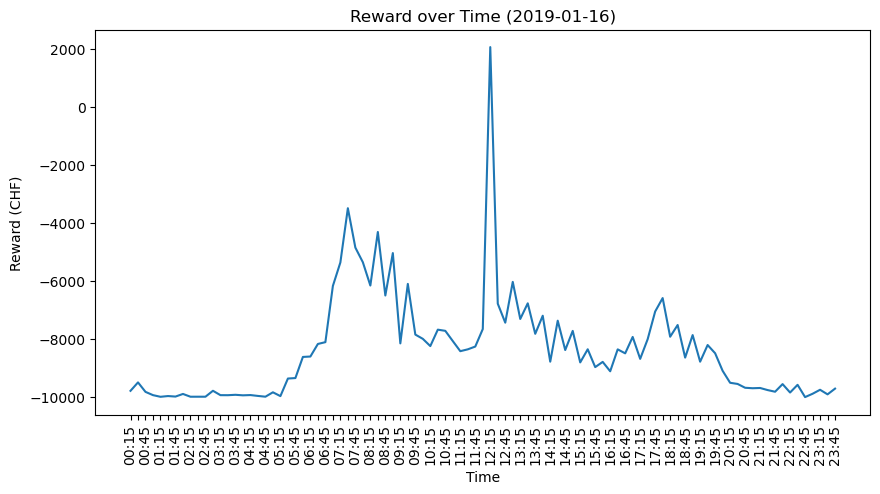

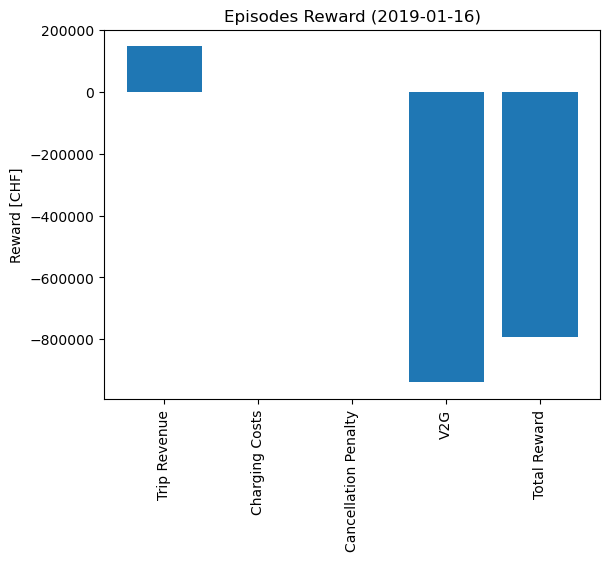

Total reward 2019-01-16:
-794221.7916875696

Total Episode Time:  1.074178695678711

Data loading:  0.0
Reward in this step: 34.8160892509956  time:  1536
Reward in this step: 96.81143811646857  time:  1537
Reward in this step: 28.620771002379144  time:  1538
Reward in this step: 112.02545833556931  time:  1539
Reward in this step: 21.514869136217143  time:  1540
Reward in this step: 20.924543885526504  time:  1541
Reward in this step: 4.110938731328468  time:  1542
Reward in this step: -2.994458869757509  time:  1543
Reward in this step: 91.58617853434922  time:  1544
Reward in this step: 73.07880050360001  time:  1545
Reward in this step: -1.795411174887033  time:  1546
Reward in this step: -1.8847163707687917  time:  1547
Reward in this step: -1.60932403907077  time:  1548
Reward in this step: -1.2482798786399991  time:  1549
Reward in this step: 57.72797662846349  time:  1550
Reward in this step: 48.38256843599999  time:  1551
Reward in this step: 37.775563738680006  time:  1552
Re

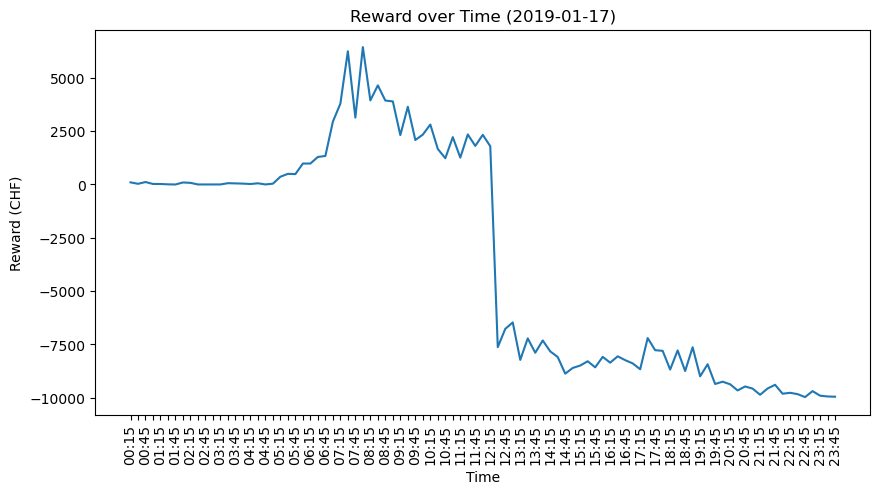

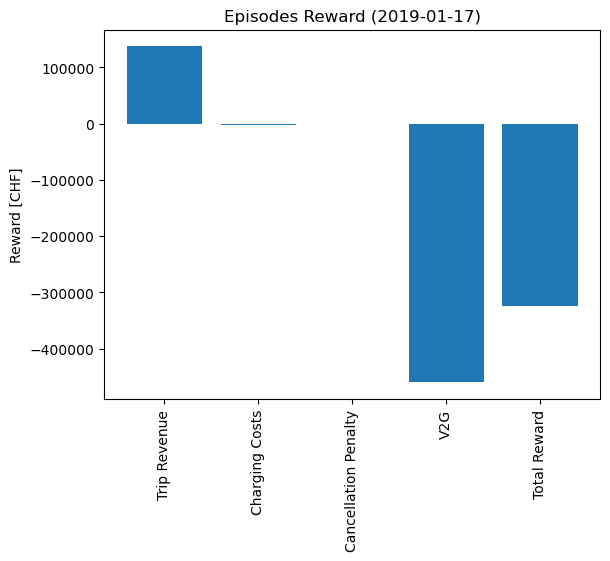

Total reward 2019-01-17:
-324225.958806501

Total Episode Time:  1.0458016395568848

Data loading:  0.0
Reward in this step: -9921.002250009416  time:  1632
Reward in this step: 36.537070728034294  time:  1633
Reward in this step: -8.463407295752765  time:  1634
Reward in this step: 67.46815548157099  time:  1635
Reward in this step: 98.35389359906199  time:  1636
Reward in this step: 19.91218538651429  time:  1637
Reward in this step: 42.8980563419622  time:  1638
Reward in this step: 108.80237246692923  time:  1639
Reward in this step: 12.783380312341102  time:  1640
Reward in this step: 136.7899427949714  time:  1641
Reward in this step: -1.70055761692835  time:  1642
Reward in this step: 20.3516465344  time:  1643
Reward in this step: 46.0652891072  time:  1644
Reward in this step: 16.22826742645443  time:  1645
Reward in this step: 155.1124410640029  time:  1646
Reward in this step: 110.04224376420001  time:  1647
Reward in this step: 131.3918083528  time:  1648
Reward in this ste

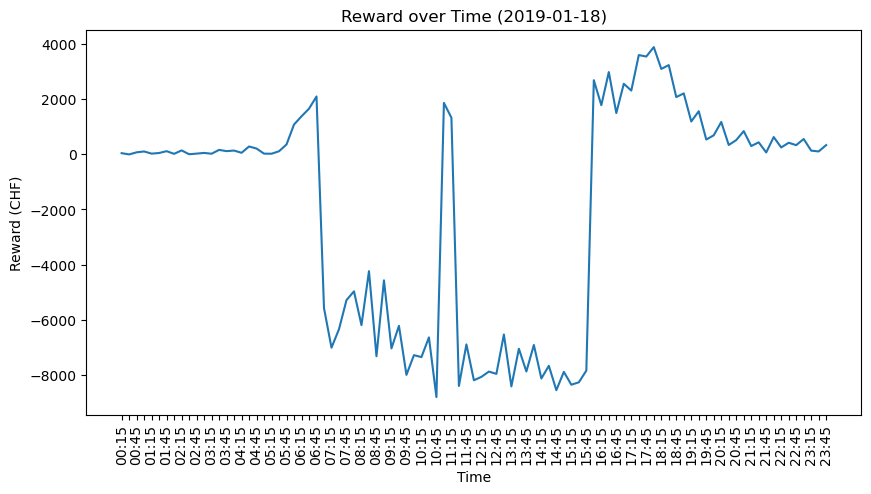

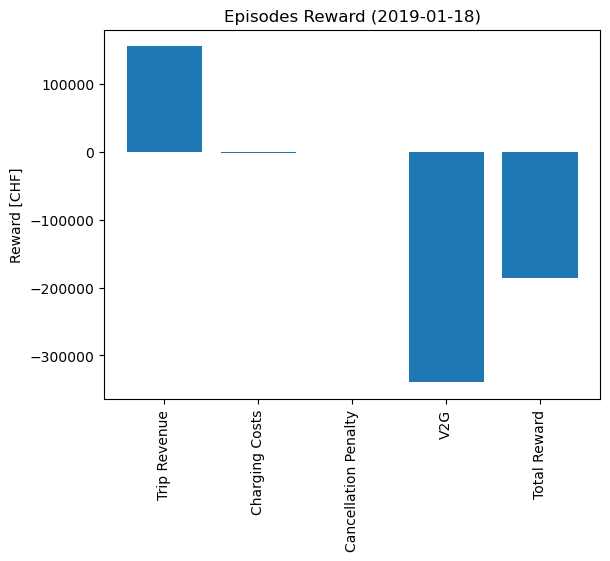

Total reward 2019-01-18:
-186482.95387911194

Total Episode Time:  1.0888152122497559

Data loading:  0.0
Reward in this step: 230.06160794578463  time:  1728
Reward in this step: -9432.600830998037  time:  1729
Reward in this step: -10000.972096601003  time:  1730
Reward in this step: -9818.683266781636  time:  1731
Reward in this step: -9897.51384566164  time:  1732
Reward in this step: -9989.42828981592  time:  1733
Reward in this step: -9958.574036778002  time:  1734
Reward in this step: -9936.461197499035  time:  1735
Reward in this step: -10006.741806085285  time:  1736
Reward in this step: -9905.265619343814  time:  1737
Reward in this step: -9959.053059404689  time:  1738
Reward in this step: -10004.33502535884  time:  1739
Reward in this step: -10003.37352938752  time:  1740
Reward in this step: -9964.122720483405  time:  1741
Reward in this step: -9771.422055987008  time:  1742
Reward in this step: -9974.890562525292  time:  1743
Reward in this step: -9967.619753602043  time:

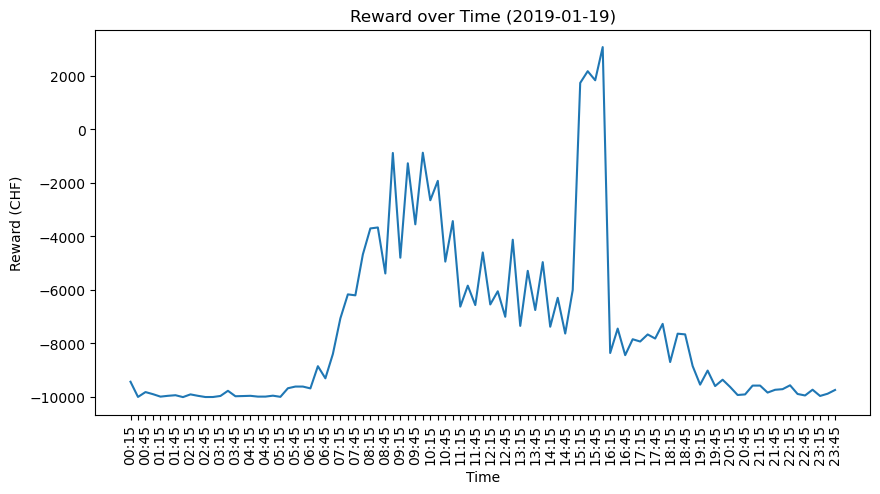

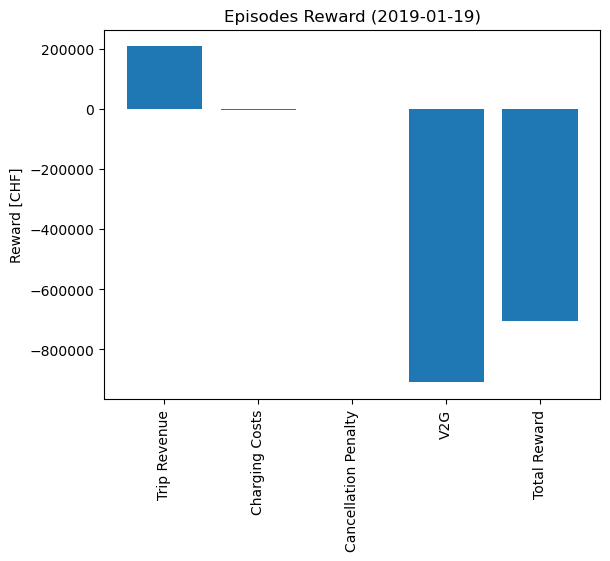

Total reward 2019-01-19:
-704633.0402290631

Total Episode Time:  1.2638053894042969

Data loading:  0.0
Reward in this step: 226.45315486685143  time:  1824
Reward in this step: 14.364464720400019  time:  1825
Reward in this step: 60.83119713834224  time:  1826
Reward in this step: 410.2887121512833  time:  1827
Reward in this step: 94.18976917033163  time:  1828
Reward in this step: 133.13517213618124  time:  1829
Reward in this step: -18.0829856511824  time:  1830
Reward in this step: 74.24990497065495  time:  1831
Reward in this step: -1.9129294264804972  time:  1832
Reward in this step: -13.215228433420657  time:  1833
Reward in this step: -11.065109441364381  time:  1834
Reward in this step: -8.55649429815559  time:  1835
Reward in this step: 6.0833151354363775  time:  1836
Reward in this step: 40.20986105084872  time:  1837
Reward in this step: 14.864388267699848  time:  1838
Reward in this step: -2.5741726744986173  time:  1839
Reward in this step: 78.53466862688  time:  1840
R

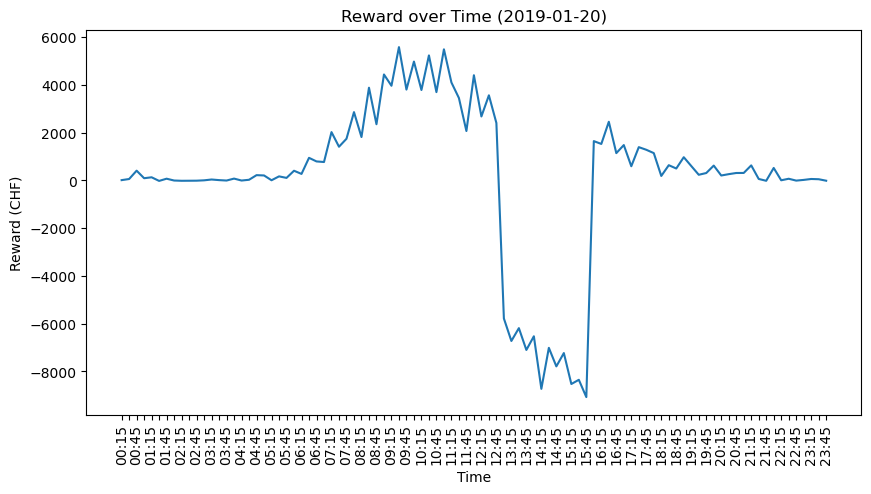

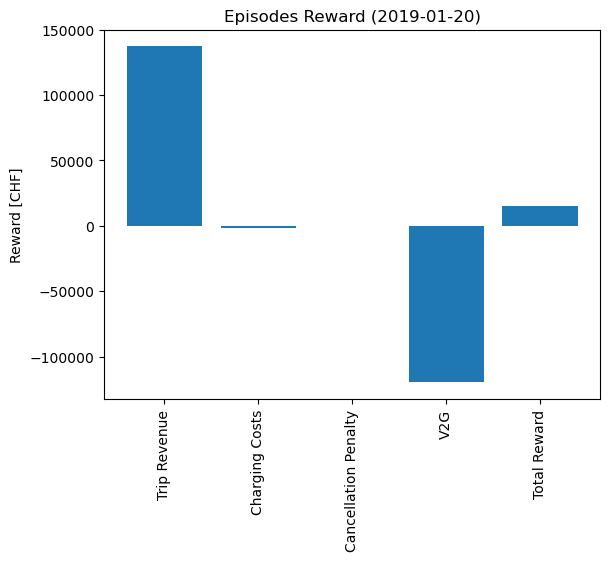

Total reward 2019-01-20:
14892.762001643832

Total Episode Time:  0.9436352252960205

Data loading:  0.0
Reward in this step: 283.49487615217583  time:  1920
Reward in this step: 285.91035101061607  time:  1921
Reward in this step: 49.02467182665994  time:  1922
Reward in this step: 390.85177688146894  time:  1923
Reward in this step: 2.7037281195578675  time:  1924
Reward in this step: -4.829691105855973  time:  1925
Reward in this step: -3.9202198707639533  time:  1926
Reward in this step: -3.0543654992004363  time:  1927
Reward in this step: 56.036163664628575  time:  1928
Reward in this step: -2.1803630914799976  time:  1929
Reward in this step: -1.8505834931999963  time:  1930
Reward in this step: -1.4959703081479367  time:  1931
Reward in this step: 81.687724886  time:  1932
Reward in this step: -1.133192509091426  time:  1933
Reward in this step: 66.93550951  time:  1934
Reward in this step: 54.51763052272  time:  1935
Reward in this step: 99.9917833984  time:  1936
Reward in th

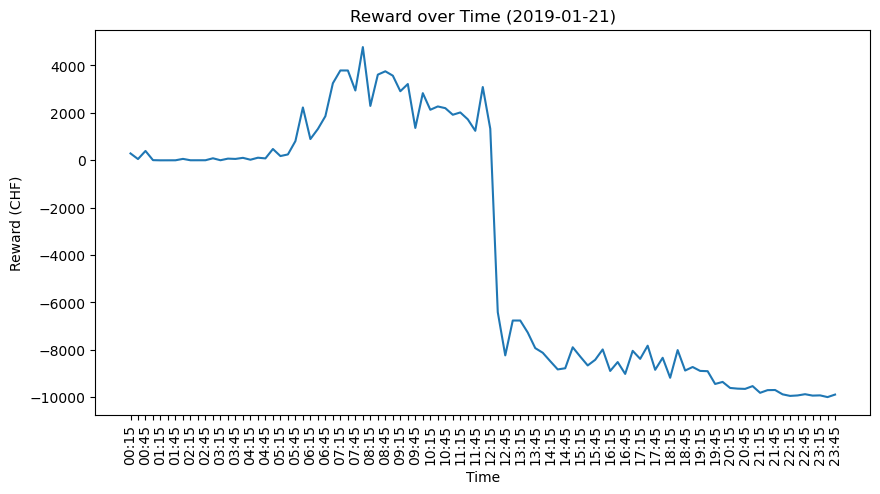

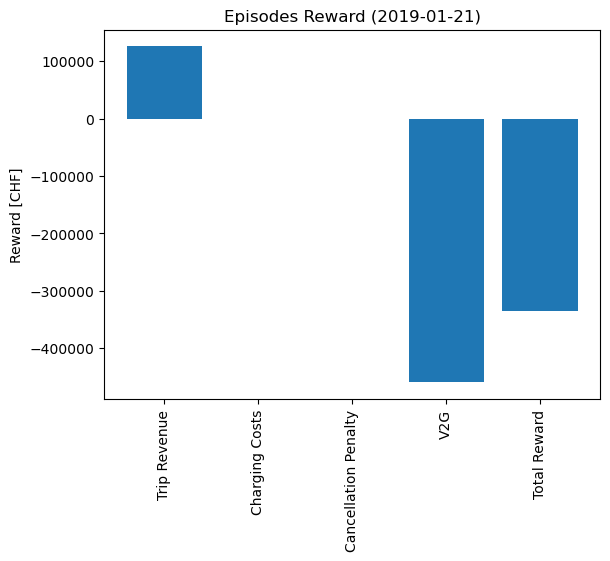

Total reward 2019-01-21:
-335832.15679808613

Total Episode Time:  0.9664006233215332

Data loading:  0.0
Reward in this step: 167.88948008301455  time:  2016
Reward in this step: 45.26772837370844  time:  2017
Reward in this step: 10.336876695727481  time:  2018
Reward in this step: 307.5220232246738  time:  2019
Reward in this step: 203.03780388308576  time:  2020
Reward in this step: 70.55330130966769  time:  2021
Reward in this step: -2.4848845581046137  time:  2022
Reward in this step: -2.2635393498643244  time:  2023
Reward in this step: 137.05706002825846  time:  2024
Reward in this step: 96.35507519762638  time:  2025
Reward in this step: -0.9821808291428562  time:  2026
Reward in this step: -0.7319701911428567  time:  2027
Reward in this step: 65.461215792  time:  2028
Reward in this step: 106.51409648414153  time:  2029
Reward in this step: 19.848407608  time:  2030
Reward in this step: 43.736163059955906  time:  2031
Reward in this step: 60.45858595792  time:  2032
Reward in

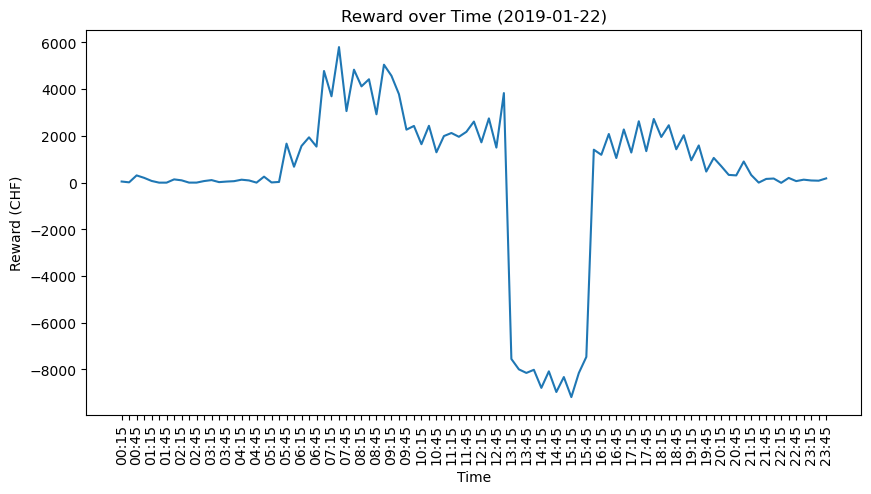

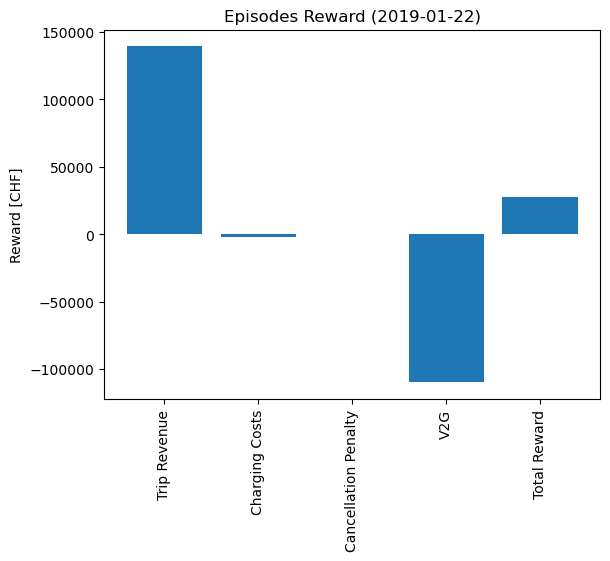

Total reward 2019-01-22:
27696.321204213324

Total Episode Time:  0.9527485370635986

Data loading:  0.0
Reward in this step: 63.15077338746684  time:  2112
Reward in this step: 35.67959945389328  time:  2113
Reward in this step: 64.30421020348001  time:  2114
Reward in this step: 150.2013216700644  time:  2115
Reward in this step: 276.6664408786954  time:  2116
Reward in this step: -4.658544885979479  time:  2117
Reward in this step: 79.15710289003077  time:  2118
Reward in this step: -3.6179682080835125  time:  2119
Reward in this step: 95.01957446853628  time:  2120
Reward in this step: 52.83467997873016  time:  2121
Reward in this step: -1.9373644428571422  time:  2122
Reward in this step: -1.4873729225714247  time:  2123
Reward in this step: 64.013190122  time:  2124
Reward in this step: 51.508169044800006  time:  2125
Reward in this step: 17.22860436219548  time:  2126
Reward in this step: 165.68992276599852  time:  2127
Reward in this step: 84.92924927381274  time:  2128
Reward 

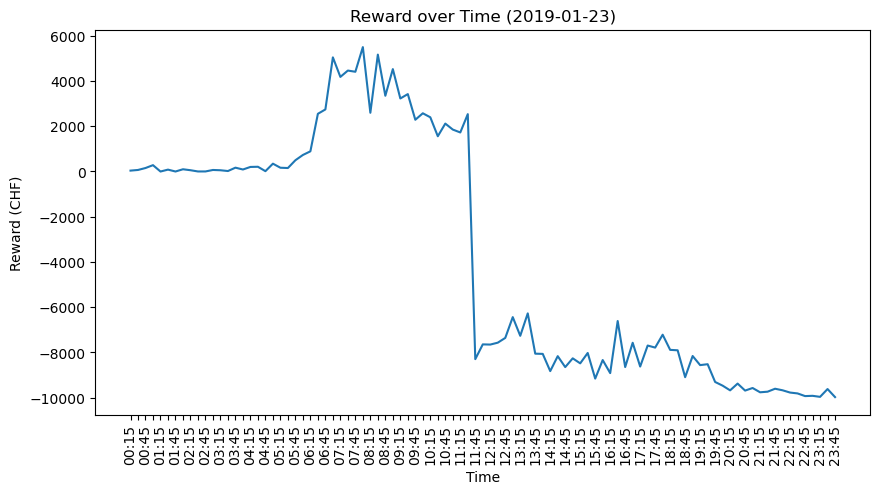

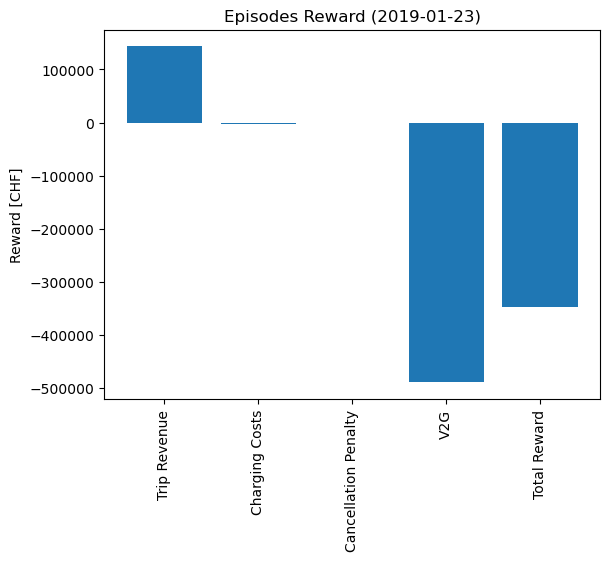

Total reward 2019-01-23:
-348119.857994684

Total Episode Time:  1.052710771560669

Data loading:  0.0
Reward in this step: -9786.078323104195  time:  2208
Reward in this step: -9917.087123243764  time:  2209
Reward in this step: -9927.647200054329  time:  2210
Reward in this step: -9851.48949890128  time:  2211
Reward in this step: -9908.933039724006  time:  2212
Reward in this step: -9970.54711618584  time:  2213
Reward in this step: -10004.09733865295  time:  2214
Reward in this step: -10003.245118828425  time:  2215
Reward in this step: -9880.070373490606  time:  2216
Reward in this step: -9980.784406922572  time:  2217
Reward in this step: -10002.060422234821  time:  2218
Reward in this step: -10001.97610123893  time:  2219
Reward in this step: -9886.207893494  time:  2220
Reward in this step: -10001.55607724512  time:  2221
Reward in this step: -9950.53295637403  time:  2222
Reward in this step: -9973.3269872176  time:  2223
Reward in this step: -10001.38507764256  time:  2224
Re

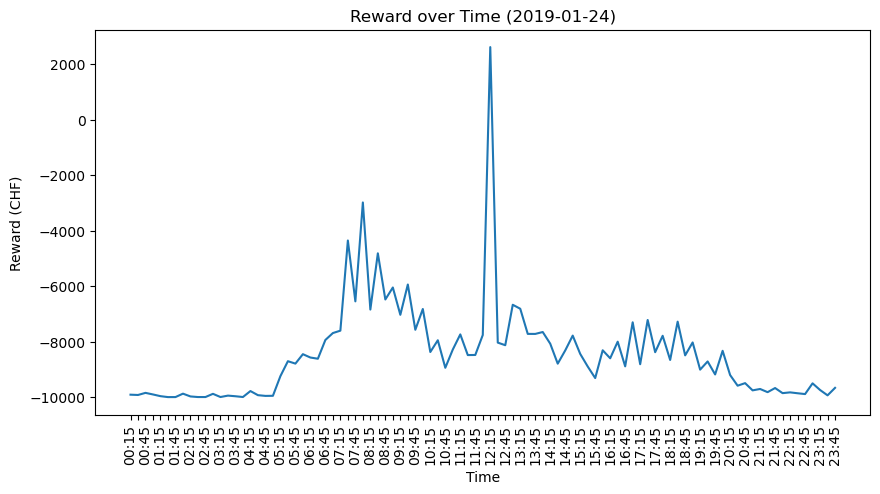

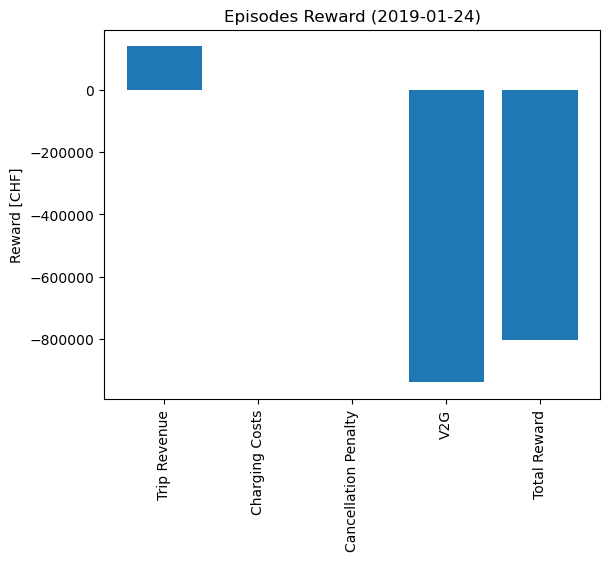

Total reward 2019-01-24:
-802567.1005566692

Total Episode Time:  1.012394905090332

Data loading:  0.0
Reward in this step: 93.8437453136976  time:  2304
Reward in this step: 36.68610134962004  time:  2305
Reward in this step: 297.6884002060281  time:  2306
Reward in this step: 249.15916993790952  time:  2307
Reward in this step: 132.1882833276926  time:  2308
Reward in this step: -5.129297794891728  time:  2309
Reward in this step: 7.527787575616715  time:  2310
Reward in this step: 711.7694042183385  time:  2311
Reward in this step: 95.06516726047295  time:  2312
Reward in this step: 15.81250795428572  time:  2313
Reward in this step: -3.371468908559997  time:  2314
Reward in this step: 18.880613997054073  time:  2315
Reward in this step: 116.1256857336  time:  2316
Reward in this step: -2.179278325439997  time:  2317
Reward in this step: 41.259898641821536  time:  2318
Reward in this step: 12.739320847839998  time:  2319
Reward in this step: 74.51913253280176  time:  2320
Reward in

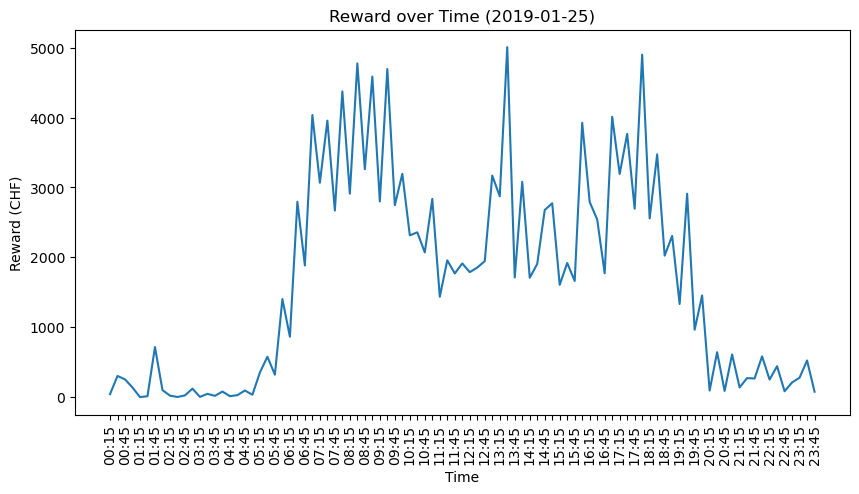

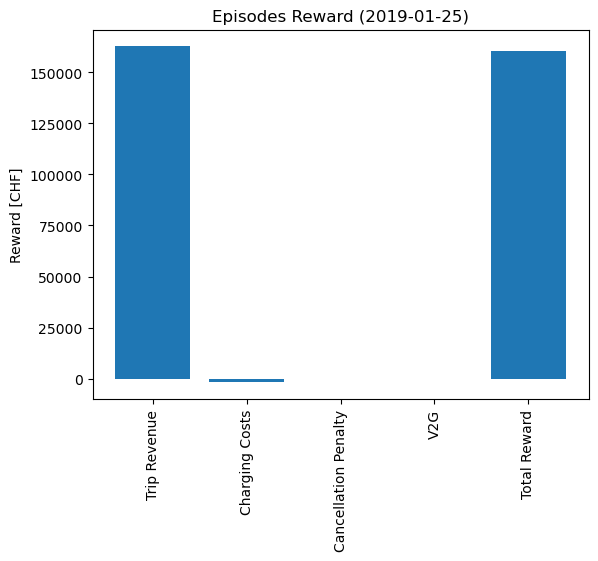

Total reward 2019-01-25:
160552.19434114525

Total Episode Time:  1.0999534130096436

Data loading:  0.0
Reward in this step: 358.5302415041396  time:  2400
Reward in this step: -9674.982751141679  time:  2401
Reward in this step: -9665.76667203252  time:  2402
Reward in this step: -9808.824592987849  time:  2403
Reward in this step: -9857.20117034218  time:  2404
Reward in this step: -9977.68526352827  time:  2405
Reward in this step: -9970.597811525617  time:  2406
Reward in this step: -9986.21494558648  time:  2407
Reward in this step: -9947.34629685532  time:  2408
Reward in this step: -9858.477354492143  time:  2409
Reward in this step: -9974.900262429353  time:  2410
Reward in this step: -9980.955819957893  time:  2411
Reward in this step: -9982.581985978855  time:  2412
Reward in this step: -10002.923940878385  time:  2413
Reward in this step: -9890.589104078766  time:  2414
Reward in this step: -9902.834047498078  time:  2415
Reward in this step: -9788.7609827708  time:  2416
R

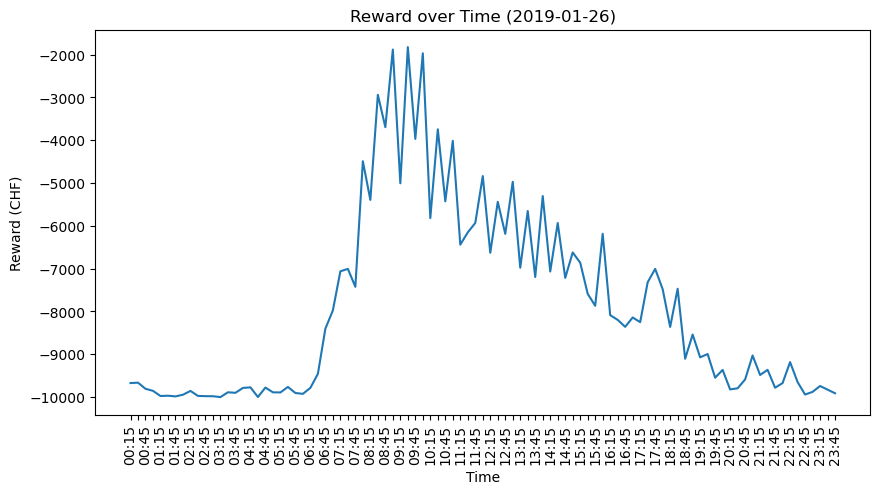

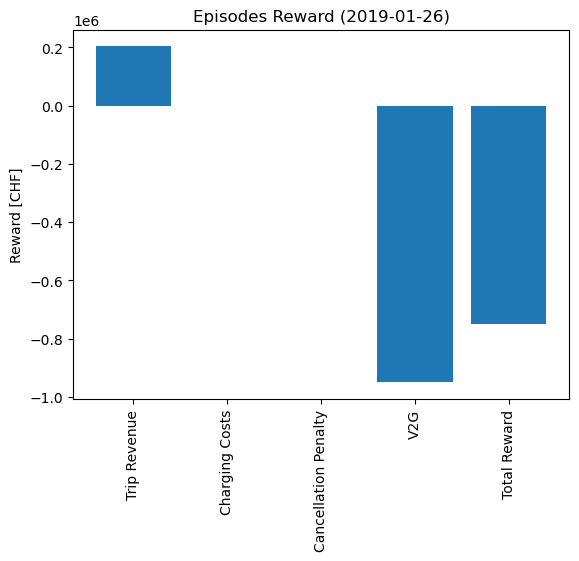

Total reward 2019-01-26:
-749672.075395655

Total Episode Time:  1.4807019233703613

Data loading:  0.0
Reward in this step: -9665.113071067704  time:  2496
Reward in this step: -9921.027737738124  time:  2497
Reward in this step: -9772.395177244336  time:  2498
Reward in this step: -9861.0620875964  time:  2499
Reward in this step: -9962.526556746163  time:  2500
Reward in this step: -9954.178463599428  time:  2501
Reward in this step: -9880.317555728761  time:  2502
Reward in this step: -10005.015181850426  time:  2503
Reward in this step: -9998.798758505554  time:  2504
Reward in this step: -9905.820299836669  time:  2505
Reward in this step: -9960.194533834268  time:  2506
Reward in this step: -10006.388788639239  time:  2507
Reward in this step: -10005.949837947046  time:  2508
Reward in this step: -9959.167704376923  time:  2509
Reward in this step: -9921.664883162675  time:  2510
Reward in this step: -9922.546857426  time:  2511
Reward in this step: -9981.844204362  time:  2512


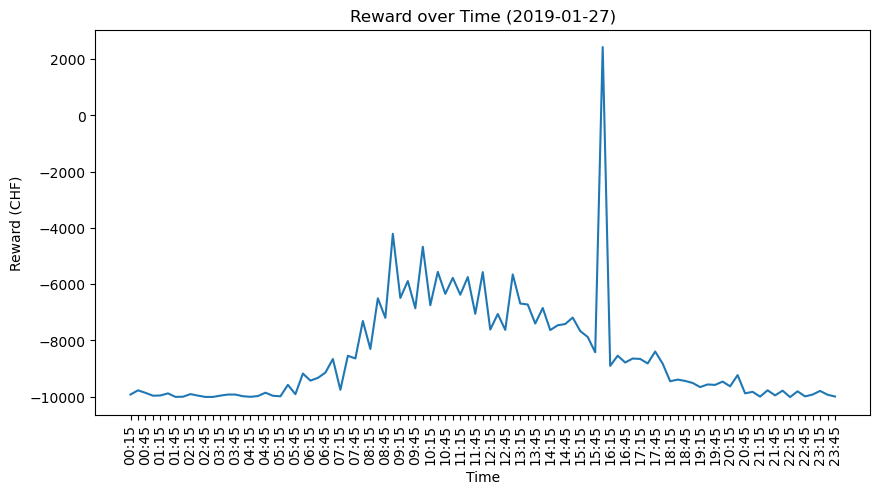

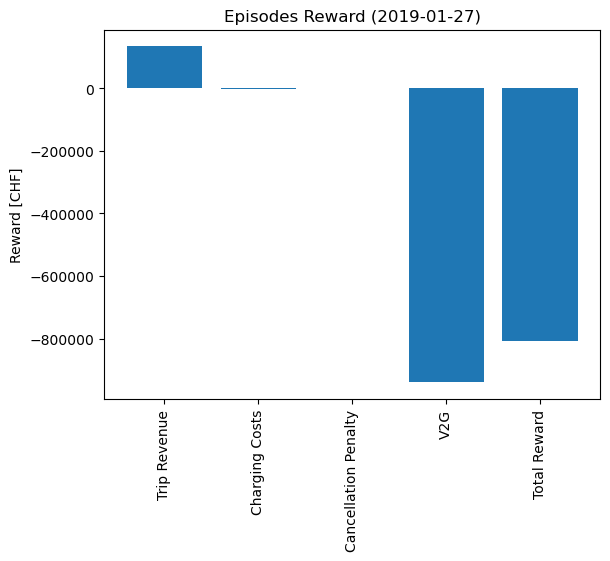

Total reward 2019-01-27:
-807486.4526852812

Total Episode Time:  0.9903378486633301

Data loading:  0.0
Reward in this step: 249.99559252651122  time:  2592
Reward in this step: 290.08913163677323  time:  2593
Reward in this step: 56.60080749007517  time:  2594
Reward in this step: 166.5967191918954  time:  2595
Reward in this step: 108.08232612167384  time:  2596
Reward in this step: -6.11120876434285  time:  2597
Reward in this step: 16.499772804264396  time:  2598
Reward in this step: 24.98994736121143  time:  2599
Reward in this step: 8.675562501028574  time:  2600
Reward in this step: 87.40561542264766  time:  2601
Reward in this step: -2.329049084845712  time:  2602
Reward in this step: -2.167515222524832  time:  2603
Reward in this step: 145.0292240512255  time:  2604
Reward in this step: 8.6945417152  time:  2605
Reward in this step: 63.151000849599995  time:  2606
Reward in this step: 7.25257256025143  time:  2607
Reward in this step: 22.754496663771434  time:  2608
Reward in

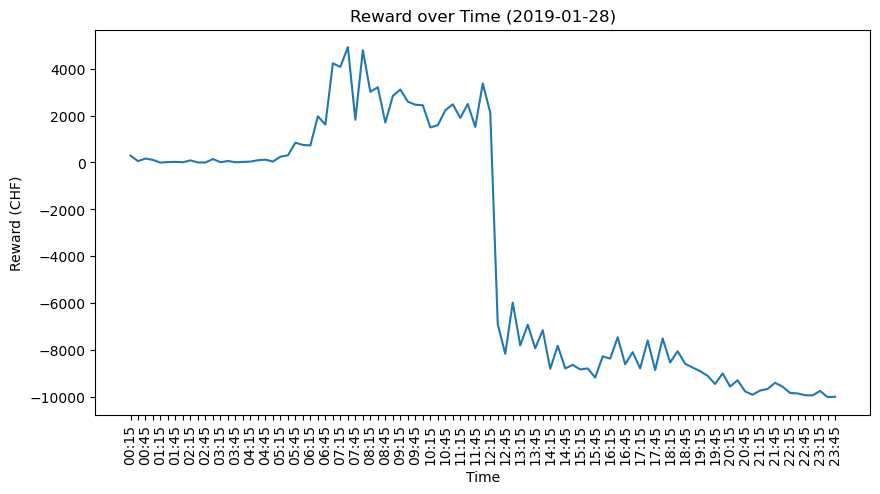

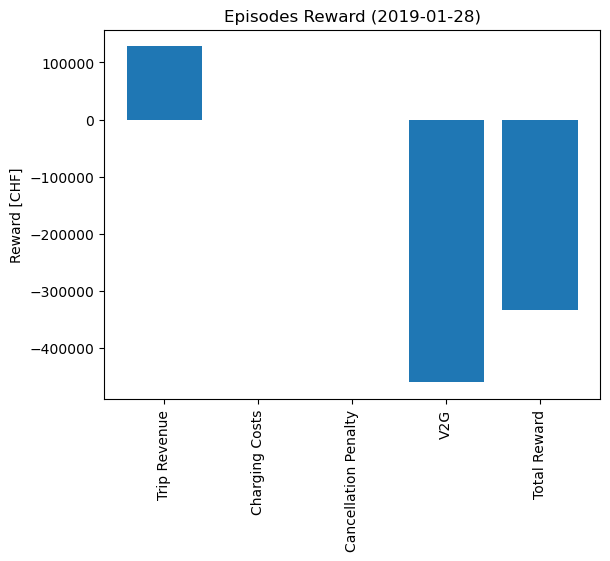

Total reward 2019-01-28:
-333668.41786850843

Total Episode Time:  0.9951608180999756

Data loading:  0.015654563903808594
Reward in this step: -9873.097082132017  time:  2688
Reward in this step: 58.64856781873869  time:  2689
Reward in this step: 6.330748499523519  time:  2690
Reward in this step: 69.74077912950506  time:  2691
Reward in this step: 170.37965129336186  time:  2692
Reward in this step: 18.565160803666764  time:  2693
Reward in this step: -2.0812513164000013  time:  2694
Reward in this step: 4.902789607200003  time:  2695
Reward in this step: 145.92070565631693  time:  2696
Reward in this step: -1.4695970282971558  time:  2697
Reward in this step: 94.9282871968  time:  2698
Reward in this step: 20.875738470399998  time:  2699
Reward in this step: -1.3599254527999918  time:  2700
Reward in this step: 28.7345501424  time:  2701
Reward in this step: 22.05096108272923  time:  2702
Reward in this step: 81.52431483960001  time:  2703
Reward in this step: -0.8171447111657111  

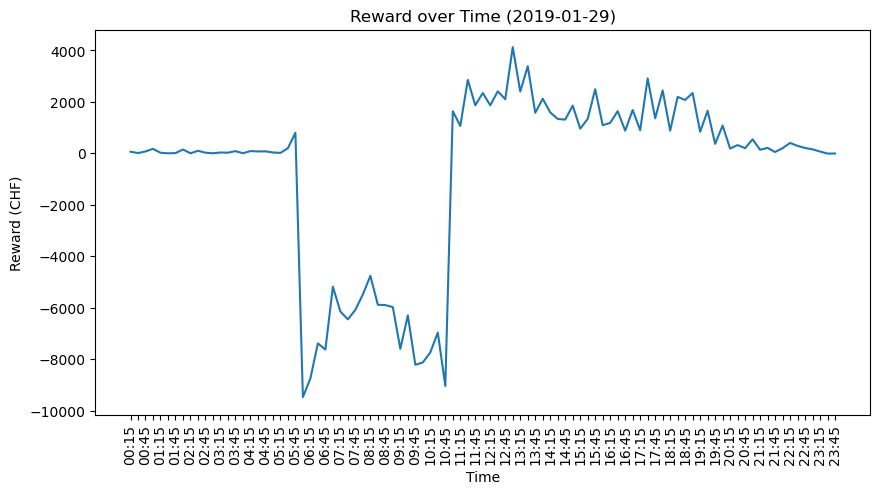

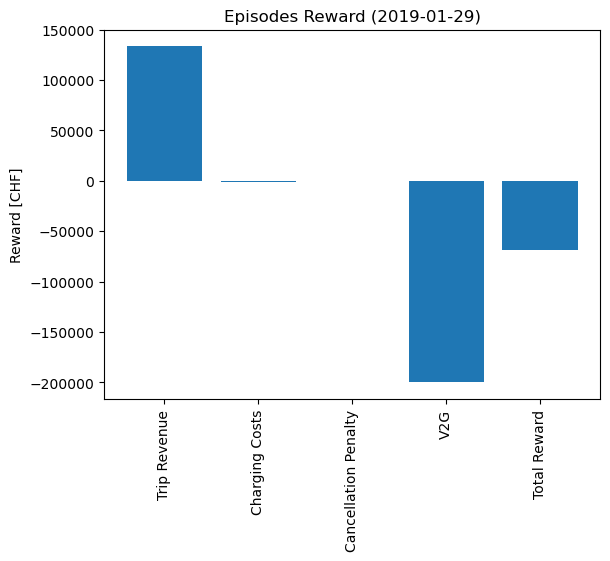

Total reward 2019-01-29:
-68224.61183880341

Total Episode Time:  0.9780449867248535

Data loading:  0.0
Reward in this step: -8.909135287011424  time:  2784
Reward in this step: 44.03435366960044  time:  2785
Reward in this step: 52.616895419886596  time:  2786
Reward in this step: 137.55458974811518  time:  2787
Reward in this step: 79.17103688658462  time:  2788
Reward in this step: -4.387746597199026  time:  2789
Reward in this step: 20.363106604837604  time:  2790
Reward in this step: -2.8358544532342798  time:  2791
Reward in this step: 66.57403003484572  time:  2792
Reward in this step: -1.7717328072000007  time:  2793
Reward in this step: -1.889848327679999  time:  2794
Reward in this step: 17.087603773760005  time:  2795
Reward in this step: -1.0989563575753853  time:  2796
Reward in this step: -1.0134149111999997  time:  2797
Reward in this step: 29.656180332984615  time:  2798
Reward in this step: 60.01830529388572  time:  2799
Reward in this step: 13.188554369999999  time: 

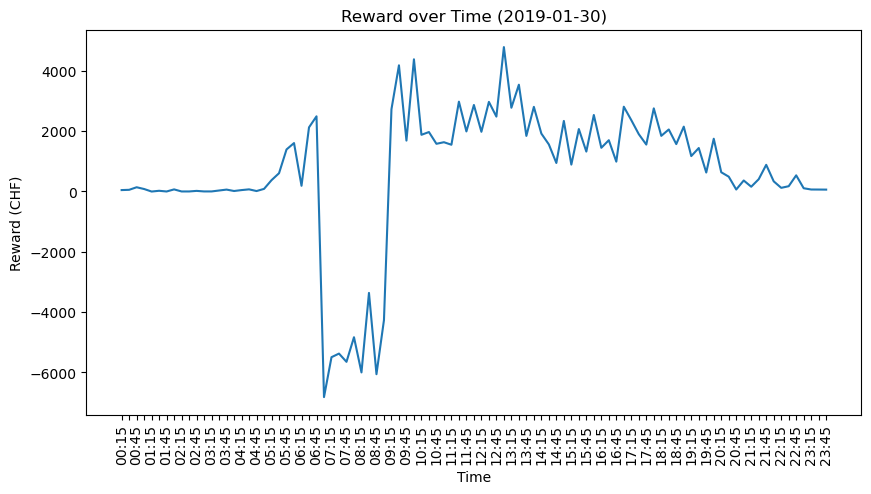

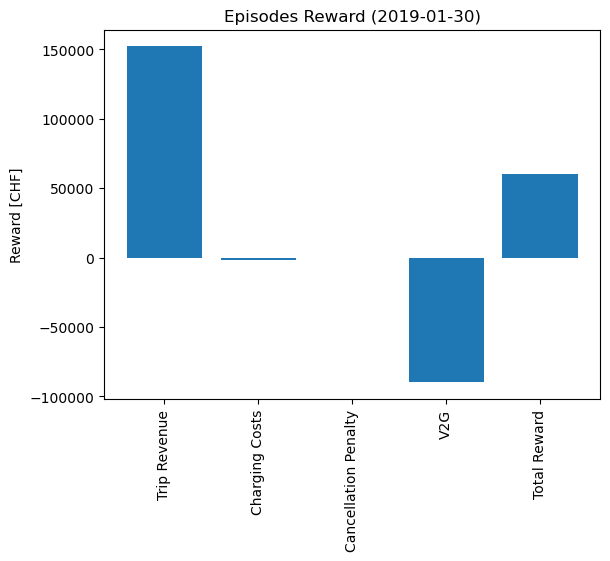

Total reward 2019-01-30:
60283.50151568236


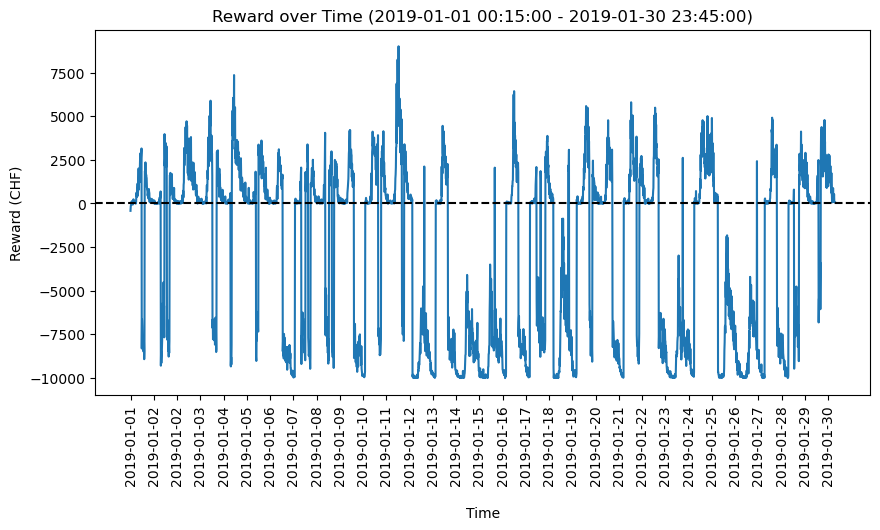

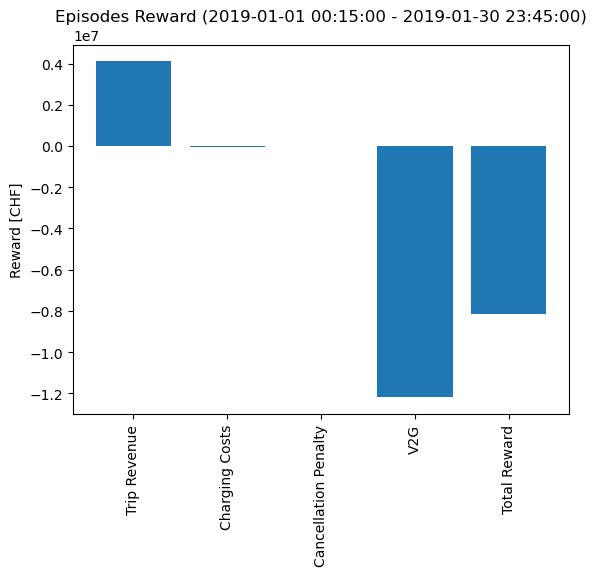

Total reward (2019-01-01 00:15:00 - 2019-01-30 23:45:00):
-8149309.472841001

Total Episode Time:  1.0463390350341797



In [13]:
# number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_reservations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_reservations = pd.read_sql(sql, engine)
    
    sql =  "SELECT * FROM msc_2023_dominik.planned_durations_discrete_{} ORDER BY vehicle_no".format(week_nr)
    planned_durations = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        timesteps_since_start = count * 96
        start = time.time()
        start2 = time.time()
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        end2 = time.time()
        print("Data loading: ", end2-start2)
        # get discete data of day
        daily_data = data.iloc[:,day-97:day-1]
        planned_reservations_day = planned_reservations.iloc[:,day-97 + 1:day + 1] 
        planned_durations_day = planned_durations.iloc[:,day-97 + 1:day + 1] 
        
        
        # reset day at begining of new episode (day)
        #s = env.reset(daily_data, reservations, timesteps_since_start, planned_reservations_day, planned_durations_day)
        
        if count == 0:
            s = env.reset(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price, planned_reservations_day, planned_durations_day)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            print("Reward in this step:", rew, " time: ", env.t)
            counter +=1
        end = time.time()
        # summary statistics of episode (day)
        env.daily_summary_statistics()
        if count == nr_iterations - 1:
            env.episode_summary_statistics(nr_iterations)
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        count += 1